In [39]:
import pickle
import pandas as pd
import matplotlib
import os
import re

import scipy

import collections
import datetime
import time

import geopandas as gpd

import numpy as np
 
from difflib import get_close_matches

from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from sklearn import linear_model

import statsmodels.api as sm
import statsmodels.formula.api as smf

from linearmodels import PanelOLS, FamaMacBeth
from scipy import stats

import itertools

import matplotlib.pyplot as plt

from numpy.linalg import matrix_rank

import seaborn as sns

## Grab Data

In [40]:
os.getcwd()

'/Users/brianreed/Documents/supplyChain/extremes/extremesAnalysisCode'

In [41]:
goodsData = pd.read_csv("../../data/companyData/goodsData.csv").drop(columns = {'Unnamed: 0'})


goodsData = goodsData[~goodsData.year.isna()]


goodsData['year'] = goodsData.year.astype('str').str.slice(0,4).astype('int64')
goodsData.columns = goodsData.columns.str.replace("0.95", "Extreme")
'''goodsData = goodsData[~goodsData.lnOpIncNormd.isna() & ~goodsData.lnRevNormd.isna() & \
         ~goodsData.lnCostNormd.isna() & ~goodsData.lnStockClose.isna()]'''
goodsData = goodsData[~goodsData.lnRevNormd.isna() & \
         ~goodsData.lnCostNormd.isna() & ~goodsData.lnStockClose.isna()]
print(goodsData.shape, goodsData.columns)

firms = goodsData['gvkey']

goodsData['excessHeat'] = goodsData.extremeHeatDaily - 9
goodsData['excessRain'] = goodsData.extremePrecipDaily - 9

goodsData['excessHeatEmp'] = goodsData.extremeHeatDays_wtd - 9
goodsData['excessRainEmp'] = goodsData.extremePrecipDays_wtd - 9

goodsData['excessHeatMax'] = goodsData.extremeHeatDays_max - 9
goodsData['excessRainMax'] = goodsData.extremePrecipDays_max - 9

goodsData['excessHeat90Plus'] = goodsData.heatDays90Plus - 9
goodsData['excessRainNational'] = goodsData.precip95National - 9

goodsData['excessHeat90PlusEmp']   = goodsData.heatDays90Plus_wtd - 9
goodsData['excessRainNationalEmp'] = goodsData.precip95National_wtd - 9

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


(105522, 1620) Index(['qtr', 'indGroup', 'sizeTercile', 'gvkey', 'year', 'weightedTempQtr',
       'weightedPrecipQtr', 'datadate', 'companyName', 'curcdq',
       ...
       'worstSupplier_excessRainEmp', 'largestSupplier_excessRainEmp',
       'wtdSupplier_excessRainEmp', 'worstSupplier_excessHeat90Plus',
       'largestSupplier_excessHeat90Plus', 'wtdSupplier_excessHeat90Plus',
       'worstSupplier_excessRain', 'largestSupplier_excessRain',
       'wtdSupplier_excessRain', 'pweights'],
      dtype='object', length=1620)


In [42]:
# goodsData = goodsData[goodsData.gvkey.isin(list(goodsData.gvkey.value_counts()[(goodsData.gvkey.value_counts() >= 4)].index))]



In [43]:
goodsData.shape

(105522, 1620)

In [44]:
sorted(goodsData.indGroup.unique())

['agForFish',
 'construction',
 'manu',
 'mining',
 'retail',
 'transportUtilities',
 'wholesale']

In [45]:
for col in goodsData.columns:
    print(col)

qtr
indGroup
sizeTercile
gvkey
year
weightedTempQtr
weightedPrecipQtr
datadate
companyName
curcdq
assets
cash
costGoodsSold
totalInv
netIncome
opInc_afDep
opInc_befDep
totalRevenue
costat
priceClose
add1
addzip
assetsLast
netIncomeLast
totalRevenueLast
costGoodsSoldLast
totalInvLast
opInc_afDepLast
opInc_befDepLast
priceCloseLast
cashLast
incomeChange
revenueChange
costChange
inventoryChange
opInc_afDepChange
opInc_befDepChange
priceCloseChange
assetsPrev
fyearq
assetsLagged
netIncomeLagged
roa_lagged
sic2
earliestYear
ageTercile
profitTercile
datacqtr
datafqtr
fyr
DATE
cstatCompanies
igCompanies
delete
abi
ticker
company
state
city
address_line_1
zipcode
latitude
longitude
precip_annual_50
precip_annual_95
precip_annual_99
precip_zip_50
precip_zip_95
precip_zip_99
precip_zipQuarter_50
precip_zipQuarter_95
precip_zipQuarter_99
temp_annual_50
temp_annual_95
temp_annual_99
temp_zip_50
temp_zip_95
temp_zip_99
temp_zipQuarter_50
temp_zipQuarter_95
temp_zipQuarter_99
lag1_precip_annual_50
l

-------------------------------------------------

### play around with the industry regressions

In [46]:
gics = pd.read_csv("../../data/companyData/gicsCodes.csv").\
    astype({'ggroup': 'str',
           'gind': 'str',
           'gsector': 'str',
           'gsubind': 'str'}).\
    rename(columns = {'fyearq': 'year'})[['gvkey','year','ggroup','gind','gsector','gsubind']].drop_duplicates()
gics.head()

,gvkey,year,ggroup,gind,gsector,gsubind
0,1004,1997,2010.0,201010.0,20.0,20101010.0
2,1004,1998,2010.0,201010.0,20.0,20101010.0
6,1004,1999,2010.0,201010.0,20.0,20101010.0
10,1004,2000,2010.0,201010.0,20.0,20101010.0
14,1004,2001,2010.0,201010.0,20.0,20101010.0


In [59]:
gicsMap = pd.read_csv("../../data/companyData/gicsMap.csv").drop(columns = {'Unnamed: 8'})

# every complete descriptor shows up with 2 lines of descriptive text
# show here the first of those and then fill in all the other values vertically
gicsMap = gicsMap[~gicsMap.gsubind.isna()].fillna(method='ffill').\
    astype({'ggroup': 'str',
           'gind': 'str',
           'gsector': 'str',
           'gsubind': 'str'}).drop_duplicates()
allGICS = gics.merge(gicsMap)

allGICS.head()

allGICS.to_csv("../../data/companyData/gicsMap_complete.csv")

In [49]:
sicsMap = pd.read_csv("../../data/companyData/sic_2_digit_codes.csv").\
    rename(columns = {'Code Value': 'sic2', 'Description' : 'sic2Desc'})
sicsMap.head()

,sic2,sic2Desc
0,1,Agricultural Production - Crops
1,2,Agricultural Production - Livestock and Animal...
2,7,Agricultural Services
3,8,Forestry
4,9,"Fishing, Hunting and Trapping"


In [50]:
goodsData.sic2

0          1
1          1
2          8
3          1
4          1
          ..
105517    51
105518    50
105519    51
105520    50
105521    50
Name: sic2, Length: 105522, dtype: int64

In [51]:
goodsData = goodsData.merge(allGICS).merge(sicsMap)

In [52]:
goodsData.ggroupDesc.value_counts()

Capital Goods                                                 14378
Technology Hardware & Equipment                               12710
Pharmaceuticals, Biotechnology & Life Sciences                11414
Energy                                                        10947
Health Care Equipment & Services                               8704
Materials                                                      7545
Consumer Durables & Apparel                                    5930
Utilities                                                      5683
Semiconductors & Semiconductor Equipment                       5501
Food, Beverage & Tobacco                                       3450
Transportation                                                 3253
Household & Personal Products                                  2380
Commercial  & Professional Services                            2325
Automobiles & Components                                       2047
Retailing                                       

In [53]:
industries = goodsData.gsectorDesc.unique()
industries

array(['Consumer Staples', 'Industrials', 'Real Estate', 'Materials',
       'Energy', 'Communication Services', 'Consumer Discretionary',
       'Information Technology', 'Health Care', 'Financials', 'Utilities'],
      dtype=object)

In [54]:
goodsData['hottest'] = 1*(goodsData.tempTercile == 3)
goodsData['coldest'] = 1*(goodsData.tempTercile == 1)




In [55]:
goodsData.shape

(104927, 1631)

In [56]:
for co in goodsData.gvkey.unique():
    print(co)

65158
160635
10390
147855
1266
19965
12466
4735
18240
5218
65675
174282
145351
21273
175686
5559
179132
63495
23195
2497
148223
21429
4818
5978
23989
179210
122754
19439
20517
6331
64997
163877
6223
23245
19516
28712
29317
26478
4515
29864
12615
8486
20237
14790
1906
8184
66660
24544
22047
18629
18004
29755
145186
2636
18171
8823
9302
12459
6865
10002
25340
16653
116324
33951
24898
158563
138662
29837
25198
176636
8073
29032
178097
29939
106261
27906
64327
140042
176017
17101
21132
21116
21136
178157
14597
108188
27784
24710
133871
141037
22496
30185
19117
15446
13235
174136
61836
13245
154605
18009
112968
5841
62525
14304
10871
12711
19138
178413
170730
24996
63162
61256
120051
5902
13184
12828
2990
27905
175472
21776
176649
17199
65280
12181
12252
29165
162770
17890
5811
10244
175649
27856
61899
3895
64857
27748
120593
162956
9521
13765
61880
13163
160272
12408
24781
65872
13786
23253
162892
107220
133504
18976
174648
135911
18172
177226
30674
25882
145206
155387
66073
22632
175424
1

16486
6196
1773
10981
20235
8213
63919
61494
12950
30671
33127
35009
2865
170418
34053
22198
29040
121196
161977
171001
61296
29254
64130
5530
5479
170994
61122
165471
110588
65054
18874
170823
63674
1094
7882
11455
1121
64063
150201
177945
10013
28762
162335
12471
14269
162876
18866
16813
18179
177924
5847
1659
179187
163935
20619
25536
3937
2751
21515
7171
11017
116029
31673
18468
174316
24891
15212


In [57]:
goodsData.to_csv("../../data/companyData/goodsData_withIndDefs.csv")

In [47]:
def getResults(outcome, weatherVar, controls, goodsData):
    equation = outcome + ' ~ ' + weatherVar + ' + ' + controls

    mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() 
    # cov_type='cluster',cov_kwds={'groups': firms})             

    # convert this into a much more condensed version
    coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
    pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])


    pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
    coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


    resultsTemp = pd.concat([coeffs,pvalues],axis = 1)
    resultsTemp['variable'] = outcome
    # resultsTemp.loc['upperVariable'] = ['^' + , '*********'] 
    
    return(resultsTemp)

    

--------------------------------

In [166]:
goodsData.yearQtr

0         2014_1
1         2014_2
2         2014_3
3         2014_4
4         2019_1
           ...  
100379    2014_4
100380    2004_4
100381    2005_4
100382    2016_4
100383    2015_4
Name: yearQtr, Length: 100384, dtype: object

In [ ]:
industryDefs = ['sic2Desc', 'indGroup', 'ggroupDesc','gindDesc','gsectorDesc','gsubindDesc']
resultList = []
results    = pd.DataFrame()   
quarters   = goodsData.qtr.unique()

for indDef in industryDefs:
    print('****************************************************')
    print(indDef)


    industries = goodsData[indDef].unique()

    outcomes = ['lnOpIncNormd', 'lnRevNormd']#, 'lnCostNormd']#, 'lnStockClose']

    weatherVars = ['excessHeat', 'excessHeatEmp','excessHeatMax', 'excessHeat90Plus',
                   'excessHeat:C(coldest)', 'excessHeatEmp:C(coldest)',
                   'excessHeatMax:C(coldest)','excessHeat90Plus:C(hottest)',
                   'excessRain', 'excessRainEmp','excessRainMax', 'excessRainNational',
                   'extremeHeatQuarterly', 'extremePrecipQuarterly',
                   'excessRain:C(coldest)', 'excessRainEmp:C(coldest)','excessRainMax:C(coldest)', 'excessRainNational:C(coldest)',
                   'extremeHeatQuarterly:C(coldest)', 'extremePrecipQuarterly:C(coldest)']
    # ['extremeHeatDaily', 'extremePrecipDaily', 'heatDays90Plus', 'precip95National']


    controls = 'C(indSeason) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'



    for outcome in outcomes:
        for weatherVar in weatherVars:
            print('##################')
            for ind in industries:
                # for qtr in quarters:
                try: 
                    print(ind)

                    tempData = goodsData[(goodsData[indDef] == ind)] # & (goodsData.qtr == qtr)]

                    resultsTemp = getResults(outcome, weatherVar, controls, tempData)

                    resultsTemp['indDef']   = indDef
                    resultsTemp['industry'] = ind
                    resultsTemp['quarter']  = 'all'
                    resultsTemp['n']        = tempData.shape[0]
                    print(resultsTemp) #outcome, weatherVar, controls, goodsData

                    results = pd.concat([results,resultsTemp], axis = 0)
                except:
                    pass
                    


resultList.append(results)
allResults = pd.concat(resultList)

allResults.to_csv('../results/resultsByInd.csv')

****************************************************
sic2Desc
##################
Agricultural Production - Crops
Forestry
Fishing, Hunting and Trapping
Construction - General Contractors & Operative Builders
Heamy Construction, Except Building Construction, Contractor
Construction - Special Trade Contractors
Measuring, Photographic, Medical, & Optical Goods, & Clocks
Chemicals and Allied Products
Electronic & Other Electrical Equipment & Components
Industrial and Commercial Machinery and Computer Equipment
Food and Kindred Products
Transportation Equipment
Lumber and Wood Products, Except Furniture
Leather and Leather Products
Rubber and Miscellaneous Plastic Products
Miscellaneous Manufacturing Industries
Furniture and Fixtures
Apparel, Finished Products from Fabrics & Similar Materials
Stone, Clay, Glass, and Concrete Products
Fabricated Metal Products
Printing, Publishing and Allied Industries
Paper and Allied Products
Primary Metal Industries
Petroleum Refining and Related Industri

Fishing, Hunting and Trapping
Construction - General Contractors & Operative Builders
Heamy Construction, Except Building Construction, Contractor
Construction - Special Trade Contractors
Measuring, Photographic, Medical, & Optical Goods, & Clocks
Chemicals and Allied Products
Electronic & Other Electrical Equipment & Components
Industrial and Commercial Machinery and Computer Equipment
Food and Kindred Products
Transportation Equipment
Lumber and Wood Products, Except Furniture
Leather and Leather Products
Rubber and Miscellaneous Plastic Products
Miscellaneous Manufacturing Industries
Furniture and Fixtures
Apparel, Finished Products from Fabrics & Similar Materials
Stone, Clay, Glass, and Concrete Products
Fabricated Metal Products
Printing, Publishing and Allied Industries
Paper and Allied Products
Primary Metal Industries
Petroleum Refining and Related Industries
Textile Mill Products
Tobacco Products
Oil and Gas Extraction
Mining and Quarrying of Nonmetallic Minerals, Except Fuel

Water Transportation
Railroad Transportation
Local & Suburban Transit & Interurban Highway Transportation
Pipelines, Except Natural Gas
Wholesale Trade - Durable Goods
Wholesale Trade - Nondurable Goods
##################
Agricultural Production - Crops
Forestry
Fishing, Hunting and Trapping
Construction - General Contractors & Operative Builders
Heamy Construction, Except Building Construction, Contractor
Construction - Special Trade Contractors
Measuring, Photographic, Medical, & Optical Goods, & Clocks
Chemicals and Allied Products
Electronic & Other Electrical Equipment & Components
Industrial and Commercial Machinery and Computer Equipment
Food and Kindred Products
Transportation Equipment
Lumber and Wood Products, Except Furniture
Leather and Leather Products
Rubber and Miscellaneous Plastic Products
Miscellaneous Manufacturing Industries
Furniture and Fixtures
Apparel, Finished Products from Fabrics & Similar Materials
Stone, Clay, Glass, and Concrete Products
Fabricated Metal P

In [ ]:
'''
['extremeHeatDaily', 'extremePrecipDaily','heatDays90Plus',
               'extremeHeatDays_wtd', 'extremePrecipDays_wtd','precip95National']
               'extremeHeatQuarterly', 'extremePrecipQuarterly', # extreme on average
              # 'heatAnomalyQuarterly', 'precipAnomalyQuarterly', # quarter above average
              # 'heatAnomalyDaily', 'precipAnomalyDaily', # days above average
               'streak90Plus', # days above 90
              'heat95National','precip95National', # national weights
              # 'heat99National','precip99National', # national weights
              'extremeHeatDays_wtd', 'extremePrecipDays_wtd', # establishments, wtd avg
              'extremeHeatDays_max', 'extremePrecipDays_max']
'''


In [ ]:
allResults.head()

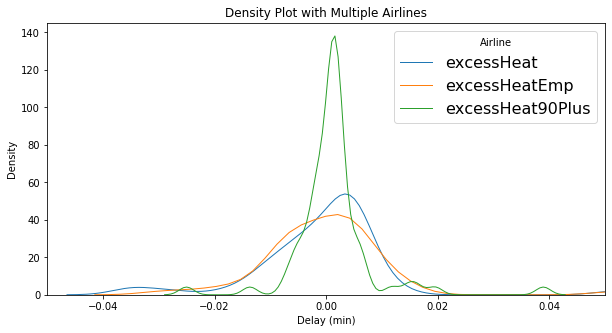

In [154]:
# List of five airlines to plot
weatherVars = list(allResults.index.unique())
plt.figure(figsize = (10, 5))

# Iterate through the five airlines
for weather in ['excessHeat', 'excessHeatEmp', 'excessHeat90Plus']:
    # Subset to the airline
    subset = allResults[(allResults.index == weather) & (allResults.pvals < 0.1)]
    
    # Draw the density plot
    sns.distplot(subset.coeffs, hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = weather)
    
# Plot formatting

plt.title('Density Plot with Multiple Airlines')
plt.xlabel('Delay (min)')
plt.xlim([-0.05, 0.05])
plt.ylabel('Density')
plt.legend(prop={'size': 16}, title = 'Airline')


In [7]:
def getResults_byInd(outcome, weatherVar, controls):
    equation = outcome + ' ~ ' + weatherVar + '*C(indGroup) + ' + controls

    mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() 
    # cov_type='cluster',cov_kwds={'groups': firms})             

    # convert this into a much more condensed version
    coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
    pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])


    pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
    coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


    resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

    resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 
    
    return(resultsTemp)

In [8]:
def getResults_bySeason(outcome, weatherVar, controls):
    equation = outcome + ' ~ ' + weatherVar + '*C(qtr) + ' + controls

    mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() 
    # cov_type='cluster',cov_kwds={'groups': firms})             

    # convert this into a much more condensed version
    coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
    pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])


    pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
    coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


    resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

    resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 
    
    return(resultsTemp)

## Simpler Results
One response across industries and across seasons.

In [26]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd']# , 'lnCostNormd', 'lnStockClose']
weatherVars = ['excessHeat', 'excessHeatEmp','excessHeatMax', 'excessHeat90Plus',
               'excessRain', 'excessRainEmp','excessRainMax', 'excessRainNational',
               'extremeHeatQuarterly', 'extremePrecipQuarterly']


controls = 'C(indSeason) + C(yearQtr) + C(gvkey)' # + C(ageTercile) + C(profitTercile) + C(sizeTercile)'
#  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults(outcome, weatherVar, controls, goodsData)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byInd = pd.concat(resultList, axis=0)

lnOpIncNormd
              coeffs     pvals      variable
excessHeat  0.000117  0.485957  lnOpIncNormd
215.75151586532593
lnRevNormd
              coeffs     pvals    variable
excessHeat -0.000912  0.001937  lnRevNormd
467.51522994041443
lnOpIncNormd
                 coeffs     pvals      variable
excessHeatEmp  0.000027  0.881836  lnOpIncNormd
709.3198249340057
lnRevNormd
                 coeffs     pvals    variable
excessHeatEmp -0.001186  0.000251  lnRevNormd
921.1160781383514
lnOpIncNormd
                 coeffs    pvals      variable
excessHeatMax -0.000114  0.45499  lnOpIncNormd
1121.8558130264282
lnRevNormd
                 coeffs     pvals    variable
excessHeatMax -0.001142  0.000022  lnRevNormd
1337.2216250896454
lnOpIncNormd
                    coeffs     pvals      variable
excessHeat90Plus -0.000144  0.056702  lnOpIncNormd
1548.496230840683
lnRevNormd
                    coeffs     pvals    variable
excessHeat90Plus -0.000222  0.095326  lnRevNormd
1734.4297020435333
lnOpI

## By Seasons
Do all of the above on subsamples. Stagger this: do precipitation results first, then for each season.

In [27]:
start = time.time()


outcomes    = ['lnOpIncNormd'] #, 'lnRevNormd'] # , 'lnStockClose']
weatherVars = ['excessHeat', 'excessRain', 'excessHeat90Plus','extremeHeatQuarterly', 'extremePrecipQuarterly']
''''excessHeatEmp','excessHeatMax', 
                'excessRainEmp','excessRainMax', 'excessRainNational','''


''''excessHeat:C(coldest)', 'excessHeatEmp:C(coldest)',
               'excessHeatMax:C(coldest)','excessHeat90Plus:C(hottest)','''

'''toKeep      = goodsData.gvkey.value_counts().index[(goodsData.gvkey.value_counts()  <= 4*19) & \
                                                   (goodsData.gvkey.value_counts()  >  4)]
                                              
'''
quarters    = list(goodsData.qtr.unique())

controls = 'C(indGroup) + C(year) + C(gvkey)' # + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for outcome in outcomes:
    for weatherVar in weatherVars:
        for quarter in quarters:
            print(quarter)
            print(goodsData[(goodsData.qtr == quarter)].shape[0])
            
            try:
                print(outcome)
                
                tempData = goodsData[(goodsData.qtr == quarter)]
                
                resultsTemp = getResults(outcome,weatherVar,controls,tempData)
                resultsTemp['quarter'] = quarter
                resultsTemp['indDef']   = 'indGroup'
                resultsTemp['industry'] = 'all'
                resultsTemp['n']        = tempData.shape[0]
                
                
                print(resultsTemp)

                results = pd.concat([results,resultsTemp], axis = 1)
                print(time.time() - start)


            except:
                print('No Dice! ' + outcome + "~" + weatherVar)
                pass
    
    
    
resultList.append(results)

allResults_bySeason = pd.concat(resultList, axis=0)


allResults_bySeason.to_csv('../results/resultsByQtr.csv')



1
25609
lnOpIncNormd
              coeffs    pvals      variable  quarter    indDef industry      n
excessHeat  0.000346  0.40491  lnOpIncNormd        1  indGroup      all  25609
77.81115508079529
2
25922
lnOpIncNormd
             coeffs     pvals      variable  quarter    indDef industry      n
excessHeat  0.00004  0.912231  lnOpIncNormd        2  indGroup      all  25922
148.3356831073761
3
25648
lnOpIncNormd
              coeffs     pvals      variable  quarter    indDef industry  \
excessHeat  0.000155  0.564208  lnOpIncNormd        3  indGroup      all   

                n  
excessHeat  25648  
236.70923399925232
4
25971
lnOpIncNormd
              coeffs     pvals      variable  quarter    indDef industry  \
excessHeat -0.000181  0.606616  lnOpIncNormd        4  indGroup      all   

                n  
excessHeat  25971  
310.2921988964081
1
25609
lnOpIncNormd
              coeffs     pvals      variable  quarter    indDef industry  \
excessRain  0.000356  0.569647  lnOpIncNormd

## By Industries
first do the responses on an ind-by-ind level

In [11]:
start = time.time()


outcomes    = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd'] # , 'lnStockClose']
weatherVars = ['extremeHeatDaily','heatDays90Plus','extremeHeatDays_wtd',
              'extremePrecipDaily','precip95National','extremePrecipDays_wtd']


'''['extremeHeatDaily','heatAnomalyDaily','extremeHeatQuarterly','heatAnomalyQuarterly',
               'heatDays90Plus','heat95National','heat99National','extremeHeatDays_wtd','extremeHeatDays_max',
               'extremePrecipDaily','precipAnomalyDaily','extremePrecipQuarterly','precipAnomalyQuarterly',
               'precip95National', 'precip99National','extremePrecipDays_wtd','extremePrecipDays_max']'''

toKeep      = goodsData.gvkey.value_counts().index[(goodsData.gvkey.value_counts()  <= 4*19) & \
                                                   (goodsData.gvkey.value_counts()  >  4)]
                                              

quarters    = list(goodsData.qtr.unique())
industries  = list(goodsData.indGroup.unique())


controls = 'C(indGroup) + C(year) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    print(weatherVar, '*****************')
    for outcome in outcomes:
        print('************************')
        for industry in industries:
            print(industry, '**********')

            try:
                print(outcome)

                resultsTemp = getResults(outcome,weatherVar,controls,goodsData[(goodsData.indGroup == industry) & \
                                                (goodsData.gvkey.isin(toKeep))])
                resultsTemp['ind'] = industry
                print(resultsTemp)

                results = pd.concat([results,resultsTemp], axis = 1)
                print(time.time() - start)


            except:
                print('No Dice! ' + outcome + "~" + weatherVar)
                pass
    
    
    
resultList.append(results)


allResults_byIndustry = pd.concat(resultList, axis=0)

extremeHeatDaily *****************
************************
transportUtilities **********
lnOpIncNormd
                         coeffs      pvals                 ind
extremeHeatDaily      -0.000475   0.169392  transportUtilities
upperVariable     ^lnOpIncNormd  *********  transportUtilities
1.7967169284820557
mining **********
lnOpIncNormd
                         coeffs      pvals     ind
extremeHeatDaily       0.000115   0.810643  mining
upperVariable     ^lnOpIncNormd  *********  mining
2.539796829223633
manu **********
lnOpIncNormd
                         coeffs      pvals   ind
extremeHeatDaily       0.000075   0.716943  manu
upperVariable     ^lnOpIncNormd  *********  manu
57.630372047424316
retail **********
lnOpIncNormd
                         coeffs      pvals     ind
extremeHeatDaily       0.001784   0.086507  retail
upperVariable     ^lnOpIncNormd  *********  retail
57.77382016181946
construction **********
lnOpIncNormd
                         coeffs      pvals           

                      coeffs      pvals           ind
heatDays90Plus      0.002479   0.000001  construction
upperVariable   ^lnCostNormd  *********  construction
381.5053160190582
wholesale **********
lnCostNormd
                      coeffs      pvals        ind
heatDays90Plus      0.000383   0.190162  wholesale
upperVariable   ^lnCostNormd  *********  wholesale
381.788006067276
agForFish **********
lnCostNormd
                      coeffs      pvals        ind
heatDays90Plus      -0.00295   0.232042  agForFish
upperVariable   ^lnCostNormd  *********  agForFish
381.8148410320282
extremeHeatDays_wtd *****************
************************
transportUtilities **********
lnOpIncNormd
                            coeffs      pvals                 ind
extremeHeatDays_wtd      -0.000581   0.122018  transportUtilities
upperVariable        ^lnOpIncNormd  *********  transportUtilities
383.8024191856384
mining **********
lnOpIncNormd
                            coeffs      pvals     ind
extrem

                          coeffs      pvals                 ind
extremePrecipDaily     -0.000654   0.508791  transportUtilities
upperVariable       ^lnCostNormd  *********  transportUtilities
675.218875169754
mining **********
lnCostNormd
                          coeffs      pvals     ind
extremePrecipDaily     -0.003156   0.124484  mining
upperVariable       ^lnCostNormd  *********  mining
675.9723329544067
manu **********
lnCostNormd
                          coeffs      pvals   ind
extremePrecipDaily     -0.000045   0.935768  manu
upperVariable       ^lnCostNormd  *********  manu
732.3609299659729
retail **********
lnCostNormd
                          coeffs      pvals     ind
extremePrecipDaily      0.003661   0.084294  retail
upperVariable       ^lnCostNormd  *********  retail
732.5199658870697
construction **********
lnCostNormd
                          coeffs      pvals           ind
extremePrecipDaily      0.002198   0.408678  construction
upperVariable       ^lnCostNormd  *

                            coeffs      pvals           ind
extremePrecipDays_wtd     0.003146   0.268626  construction
upperVariable          ^lnRevNormd  *********  construction
1024.7904670238495
wholesale **********
lnRevNormd
                            coeffs      pvals        ind
extremePrecipDays_wtd    -0.001316   0.381097  wholesale
upperVariable          ^lnRevNormd  *********  wholesale
1025.0589880943298
agForFish **********
lnRevNormd
                            coeffs      pvals        ind
extremePrecipDays_wtd    -0.031116   0.002825  agForFish
upperVariable          ^lnRevNormd  *********  agForFish
1025.086067199707
************************
transportUtilities **********
lnCostNormd
                             coeffs      pvals                 ind
extremePrecipDays_wtd     -0.000854   0.419277  transportUtilities
upperVariable          ^lnCostNormd  *********  transportUtilities
1026.858031988144
mining **********
lnCostNormd
                             coeffs      p

In [13]:
allResults_byIndustry.to_csv("../../data/companyData/allResults_byIndustry.csv")

try by quarter; it seems a little tough to identify effects by industry by season

In [9]:
start = time.time()


outcomes    = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd'] # , 'lnStockClose']
weatherVars = ['extremeHeatDaily','heatDays90Plus','extremeHeatDays_wtd',
              'extremePrecipDaily','precip95National','extremePrecipDays_wtd']


'''['extremeHeatDaily','heatAnomalyDaily','extremeHeatQuarterly','heatAnomalyQuarterly',
               'heatDays90Plus','heat95National','heat99National','extremeHeatDays_wtd','extremeHeatDays_max',
               'extremePrecipDaily','precipAnomalyDaily','extremePrecipQuarterly','precipAnomalyQuarterly',
               'precip95National', 'precip99National','extremePrecipDays_wtd','extremePrecipDays_max']'''

toKeep      = goodsData.gvkey.value_counts().index[(goodsData.gvkey.value_counts()  <= 4*19) & \
                                                   (goodsData.gvkey.value_counts()  >  4)]
                                              

quarters    = list(goodsData.qtr.unique())
industries  = list(goodsData.indGroup.unique())


controls = 'C(indGroup) + C(year) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    print(weatherVar, '*****************')
    for outcome in outcomes:
        print('************************')
        for industry in industries:
            print(industry, '**********')
            for quarter in quarters:
                print(quarter)


                try:
                    print(outcome)

                    resultsTemp = getResults(outcome,weatherVar,controls,goodsData[(goodsData.indGroup == industry) & \
                                                                                   (goodsData.qtr == quarter) & \
                                                    (goodsData.gvkey.isin(toKeep))])
                    resultsTemp['qtr'] = quarter
                    print(resultsTemp)

                    results = pd.concat([results,resultsTemp], axis = 1)
                    print(time.time() - start)


                except:
                    print('No Dice! ' + outcome + "~" + weatherVar)
                    pass
    
    
    
resultList.append(results)


allResults_bySeason = pd.concat(resultList, axis=0)

extremeHeatDaily *****************
************************
transportUtilities **********
1
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily       0.000644   0.484792    1
upperVariable     ^lnOpIncNormd  *********    1
0.6401510238647461
2
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily      -0.001519   0.062434    2
upperVariable     ^lnOpIncNormd  *********    2
1.2642090320587158
3
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily      -0.000921   0.119389    3
upperVariable     ^lnOpIncNormd  *********    3
1.8600459098815918
4
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily      -0.000139    0.84956    4
upperVariable     ^lnOpIncNormd  *********    4
2.5531089305877686
mining **********
1
lnOpIncNormd
                         coeffs      pvals  qtr
extremeHeatDaily       0.000392   0.828497    1
upperVariable     ^lnOpIncNormd  *********    1
2.8344109058380127
2


                       coeffs      pvals  qtr
extremeHeatDaily    -0.002805   0.291572    1
upperVariable     ^lnRevNormd  *********    1
190.3756880760193
2
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily      0.00166   0.457238    2
upperVariable     ^lnRevNormd  *********    2
190.47827816009521
3
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily    -0.001242    0.43584    3
upperVariable     ^lnRevNormd  *********    3
190.59735012054443
4
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily     -0.00229   0.283994    4
upperVariable     ^lnRevNormd  *********    4
190.69757890701294
agForFish **********
1
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily     0.004137   0.793985    1
upperVariable     ^lnRevNormd  *********    1
190.7150640487671
2
lnRevNormd
                       coeffs      pvals  qtr
extremeHeatDaily    -0.012563   0.359412    2
upperVariable     ^lnRevNormd  ********

                       coeffs      pvals  qtr
heatDays90Plus      -0.000097   0.664987    3
upperVariable   ^lnOpIncNormd  *********    3
339.6186978816986
4
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus      -0.000514    0.08418    4
upperVariable   ^lnOpIncNormd  *********    4
360.8245849609375
retail **********
1
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus       0.005117    0.39419    1
upperVariable   ^lnOpIncNormd  *********    1
360.8967640399933
2
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus       0.003688   0.142959    2
upperVariable   ^lnOpIncNormd  *********    2
360.9641070365906
3
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus       0.001017   0.370878    3
upperVariable   ^lnOpIncNormd  *********    3
361.033164024353
4
lnOpIncNormd
                       coeffs      pvals  qtr
heatDays90Plus       0.001669   0.234694    4
upperVariable   ^lnOpIncNormd  *****

                      coeffs      pvals  qtr
heatDays90Plus     -0.000011   0.987462    3
upperVariable   ^lnCostNormd  *********    3
453.9673159122467
4
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus       0.00118   0.151319    4
upperVariable   ^lnCostNormd  *********    4
454.8173098564148
mining **********
1
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus     -0.001436   0.859776    1
upperVariable   ^lnCostNormd  *********    1
455.16482615470886
2
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus     -0.001616   0.528747    2
upperVariable   ^lnCostNormd  *********    2
455.51799607276917
3
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus     -0.002057   0.126999    3
upperVariable   ^lnCostNormd  *********    3
455.9002721309662
4
lnCostNormd
                      coeffs      pvals  qtr
heatDays90Plus     -0.002767   0.129844    4
upperVariable   ^lnCostNormd  *********    4
456.253595

                            coeffs      pvals  qtr
extremeHeatDays_wtd       0.002154   0.296749    1
upperVariable        ^lnOpIncNormd  *********    1
613.7781779766083
2
lnOpIncNormd
                            coeffs      pvals  qtr
extremeHeatDays_wtd        0.00287   0.097332    2
upperVariable        ^lnOpIncNormd  *********    2
613.8649771213531
3
lnOpIncNormd
                            coeffs      pvals  qtr
extremeHeatDays_wtd       0.001364    0.27845    3
upperVariable        ^lnOpIncNormd  *********    3
613.9628751277924
4
lnOpIncNormd
                            coeffs      pvals  qtr
extremeHeatDays_wtd        0.00234   0.178481    4
upperVariable        ^lnOpIncNormd  *********    4
614.0797901153564
agForFish **********
1
lnOpIncNormd
                            coeffs      pvals  qtr
extremeHeatDays_wtd       0.010119   0.150147    1
upperVariable        ^lnOpIncNormd  *********    1
614.0998330116272
2
lnOpIncNormd
                            coeffs      pvals  qt

                           coeffs      pvals  qtr
extremeHeatDays_wtd      0.000018   0.979926    3
upperVariable        ^lnCostNormd  *********    3
753.2018659114838
4
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd     -0.000455   0.611431    4
upperVariable        ^lnCostNormd  *********    4
775.4823231697083
retail **********
1
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd      0.006991   0.082195    1
upperVariable        ^lnCostNormd  *********    1
775.5557010173798
2
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd      0.004344   0.188121    2
upperVariable        ^lnCostNormd  *********    2
775.6304290294647
3
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd      0.000015    0.99503    3
upperVariable        ^lnCostNormd  *********    3
775.7032239437103
4
lnCostNormd
                           coeffs      pvals  qtr
extremeHeatDays_wtd   

                         coeffs      pvals  qtr
extremePrecipDaily     0.003844   0.087745    1
upperVariable       ^lnRevNormd  *********    1
864.6911089420319
2
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily     -0.00056   0.796133    2
upperVariable       ^lnRevNormd  *********    2
865.3132970333099
3
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily    -0.001019   0.620205    3
upperVariable       ^lnRevNormd  *********    3
865.9137010574341
4
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily     0.001993   0.347941    4
upperVariable       ^lnRevNormd  *********    4
866.4983332157135
mining **********
1
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily    -0.005558   0.256345    1
upperVariable       ^lnRevNormd  *********    1
866.8492739200592
2
lnRevNormd
                         coeffs      pvals  qtr
extremePrecipDaily    -0.004604   0.242299    2
upperVariab

                          coeffs      pvals  qtr
extremePrecipDaily      0.011152   0.060808    3
upperVariable       ^lnCostNormd  *********    3
1034.3632769584656
4
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily      0.008603   0.230017    4
upperVariable       ^lnCostNormd  *********    4
1034.4086329936981
wholesale **********
1
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily      0.000479   0.903479    1
upperVariable       ^lnCostNormd  *********    1
1034.5956048965454
2
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily      0.001373   0.697411    2
upperVariable       ^lnCostNormd  *********    2
1034.738727092743
3
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily     -0.000861   0.785123    3
upperVariable       ^lnCostNormd  *********    3
1034.8631620407104
4
lnCostNormd
                          coeffs      pvals  qtr
extremePrecipDaily      0.00172

                       coeffs      pvals  qtr
precip95National     0.001466    0.80918    4
upperVariable     ^lnRevNormd  *********    4
1123.6055040359497
manu **********
1
lnRevNormd
                       coeffs      pvals  qtr
precip95National     0.000269    0.89031    1
upperVariable     ^lnRevNormd  *********    1
1144.6622409820557
2
lnRevNormd
                       coeffs      pvals  qtr
precip95National    -0.000459   0.819784    2
upperVariable     ^lnRevNormd  *********    2
1164.2243909835815
3
lnRevNormd
                       coeffs      pvals  qtr
precip95National    -0.005631    0.00312    3
upperVariable     ^lnRevNormd  *********    3
1184.3985130786896
4
lnRevNormd
                       coeffs      pvals  qtr
precip95National     0.001044   0.582023    4
upperVariable     ^lnRevNormd  *********    4
1205.2510488033295
retail **********
1
lnRevNormd
                       coeffs      pvals  qtr
precip95National     0.009772   0.130283    1
upperVariable     ^lnRev

                              coeffs      pvals  qtr
extremePrecipDays_wtd       0.000925   0.508149    1
upperVariable          ^lnOpIncNormd  *********    1
1293.8468918800354
2
lnOpIncNormd
                              coeffs      pvals  qtr
extremePrecipDays_wtd      -0.000528   0.689387    2
upperVariable          ^lnOpIncNormd  *********    2
1295.1718928813934
3
lnOpIncNormd
                              coeffs      pvals  qtr
extremePrecipDays_wtd      -0.001366   0.254356    3
upperVariable          ^lnOpIncNormd  *********    3
1295.883213043213
4
lnOpIncNormd
                              coeffs      pvals  qtr
extremePrecipDays_wtd        0.00133   0.321974    4
upperVariable          ^lnOpIncNormd  *********    4
1296.8005721569061
mining **********
1
lnOpIncNormd
                              coeffs      pvals  qtr
extremePrecipDays_wtd       0.000211   0.937809    1
upperVariable          ^lnOpIncNormd  *********    1
1297.2215337753296
2
lnOpIncNormd
                  

                            coeffs      pvals  qtr
extremePrecipDays_wtd     0.004083   0.317145    3
upperVariable          ^lnRevNormd  *********    3
1460.291698217392
4
lnRevNormd
                            coeffs      pvals  qtr
extremePrecipDays_wtd     0.002295   0.595955    4
upperVariable          ^lnRevNormd  *********    4
1460.4144930839539
construction **********
1
lnRevNormd
                            coeffs      pvals  qtr
extremePrecipDays_wtd     0.005847   0.452187    1
upperVariable          ^lnRevNormd  *********    1
1460.4558718204498
2
lnRevNormd
                            coeffs      pvals  qtr
extremePrecipDays_wtd    -0.001528   0.820237    2
upperVariable          ^lnRevNormd  *********    2
1460.5025351047516
3
lnRevNormd
                            coeffs      pvals  qtr
extremePrecipDays_wtd     0.002773   0.661804    3
upperVariable          ^lnRevNormd  *********    3
1460.5441398620605
4
lnRevNormd
                            coeffs      pvals  qtr
e

In [15]:
allResults_bySeason.to_csv("../../data/companyData/allResults_bySeason.csv")

below we have more on the interactions front. i don't think these are super promising but are worth keeping in line and in mind.

-------------------------

## By Background Climate
first, terciles of this

In [11]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd'] #, 'lnCostNormd'] #, 'lnStockClose']
weatherVars = ['extremeHeatDaily*C(tempTercile)', 'heatDays90Plus*C(tempTercile)', # 'streak90Plus*C(tempTercile)',  # days of extremes
              #'extremeHeatQuarterly*C(tempTercile)', 'extremePrecipQuarterly*C(precipTercile)', # extreme on average
              #'heatAnomalyQuarterly*C(tempTercile)', 'precipAnomalyQuarterly*C(precipTercile)', # quarter above average
              # 'heatAnomalyDaily*C(tempTercile)', 'precipAnomalyDaily*C(precipTercile)', # days above average
              # 'heat95National*C(tempTercile)', # days above 90
              'extremePrecipDaily*C(precipTercile)',
              'extremeHeatDays_wtd*C(tempTercile)', 'extremePrecipDays_wtd*C(precipTercile)']
              #'heat99National*C(tempTercile)','precip99National*C(precipTercile)']


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()
mglResults = pd.DataFrame()


for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults(outcome, weatherVar, controls, goodsData)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byTercile = pd.concat(resultList, axis=0)

lnOpIncNormd
                                             coeffs      pvals
extremeHeatDaily                           0.000727   0.039246
extremeHeatDaily:C(tempTercile)[T.2]      -0.001295   0.003639
extremeHeatDaily:C(tempTercile)[T.3]      -0.000404   0.329318
upperVariable                         ^lnOpIncNormd  *********
247.6093990802765
                                  coeff   effects
0                      extremeHeatDaily  0.000727
1  extremeHeatDaily:C(tempTercile)[T.2] -0.000568
2  extremeHeatDaily:C(tempTercile)[T.3]  0.000323
lnRevNormd
                                           coeffs      pvals
extremeHeatDaily                        -0.000369   0.552856
extremeHeatDaily:C(tempTercile)[T.2]    -0.000865   0.270651
extremeHeatDaily:C(tempTercile)[T.3]    -0.000619   0.396854
upperVariable                         ^lnRevNormd  *********
521.1374042034149
                                  coeff   effects
0                      extremeHeatDaily -0.000369
1  extremeHeatDaily:

# next, do it by just hot/cold, wet/dry

In [13]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']
weatherVars = ['extremeHeatDaily*C(tempHalf)', 'extremePrecipDaily*C(precipHalf)', # days of extremes
              'extremeHeatQuarterly*C(tempHalf)', 'extremePrecipQuarterly*C(precipHalf)', # extreme on average
              'heatDays90Plus*C(tempHalf)', 'streak90Plus*C(tempHalf)']


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()
mglResults = pd.DataFrame()


for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults(outcome, weatherVar, controls, goodsData)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byTercile = pd.concat(resultList, axis=0)

lnOpIncNormd
                                          coeffs      pvals
extremeHeatDaily                        0.000013   0.963066
extremeHeatDaily:C(tempHalf)[T.2]       0.000224    0.49828
upperVariable                      ^lnOpIncNormd  *********
320.30242705345154
                               coeff   effects
0                   extremeHeatDaily  0.000013
1  extremeHeatDaily:C(tempHalf)[T.2]  0.000236
lnRevNormd
                                        coeffs      pvals
extremeHeatDaily                      -0.00068   0.163471
extremeHeatDaily:C(tempHalf)[T.2]    -0.000355   0.541926
upperVariable                      ^lnRevNormd  *********
625.8721640110016
                               coeff   effects
0                   extremeHeatDaily -0.000680
1  extremeHeatDaily:C(tempHalf)[T.2] -0.001035
lnCostNormd
                                         coeffs      pvals
extremeHeatDaily                      -0.000306   0.526869
extremeHeatDaily:C(tempHalf)[T.2]     -0.000732   0.204

                                      coeffs      pvals
streak90Plus                        0.000946   0.866402
streak90Plus:C(tempHalf)[T.2]       0.005686   0.471853
upperVariable                  ^lnOpIncNormd  *********
6283.489735126495
                           coeff   effects
0                   streak90Plus  0.000946
1  streak90Plus:C(tempHalf)[T.2]  0.006633
lnRevNormd
                                    coeffs      pvals
streak90Plus                     -0.015491   0.118353
streak90Plus:C(tempHalf)[T.2]     0.022494   0.106555
upperVariable                  ^lnRevNormd  *********
6652.1100199222565
                           coeff   effects
0                   streak90Plus -0.015491
1  streak90Plus:C(tempHalf)[T.2]  0.007003
lnCostNormd
                                     coeffs      pvals
streak90Plus                       0.012381   0.208292
streak90Plus:C(tempHalf)[T.2]     -0.012644   0.360468
upperVariable                  ^lnCostNormd  *********
6922.329827070236
    

Look at either terciles or halves when defining extremes by industry.

In [15]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['extremeHeatDaily*C(tempHalf_byInd)', 'extremePrecipDaily*C(precipHalf_byInd)', # days of extremes
              'extremeHeatQuarterly*C(tempHalf_byInd)', 'extremePrecipQuarterly*C(precipHalf_byInd)', # extreme on average
              'heatDays90Plus*C(tempHalf_byInd)', 'streak90Plus*C(tempHalf_byInd)',
              'extremeHeatDaily*C(tempTercile_byInd)', 'extremePrecipDaily*C(precipTercile_byInd)', # days of extremes
              'extremeHeatQuarterly*C(tempTercile_byInd)', 'extremePrecipQuarterly*C(precipTercile_byInd)', # extreme on average
              'heatDays90Plus*C(tempTercile_byInd)', 'streak90Plus*C(tempTercile_byInd)']


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()
mglResults = pd.DataFrame()


for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults(outcome, weatherVar, controls, goodsData)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byTercile = pd.concat(resultList, axis=0)

lnOpIncNormd
                                                coeffs      pvals
extremeHeatDaily                             -0.000056     0.8384
extremeHeatDaily:C(tempHalf_byInd)[T.2]       0.000328   0.317959
upperVariable                            ^lnOpIncNormd  *********
271.02412724494934
                                     coeff   effects
0                         extremeHeatDaily -0.000056
1  extremeHeatDaily:C(tempHalf_byInd)[T.2]  0.000272
lnRevNormd
                                              coeffs      pvals
extremeHeatDaily                           -0.000706   0.144792
extremeHeatDaily:C(tempHalf_byInd)[T.2]    -0.000319   0.581901
upperVariable                            ^lnRevNormd  *********
587.830372095108
                                     coeff   effects
0                         extremeHeatDaily -0.000706
1  extremeHeatDaily:C(tempHalf_byInd)[T.2] -0.001025
lnCostNormd
                                               coeffs      pvals
extremeHeatDaily         

                                             coeffs      pvals
heatDays90Plus                            -0.000329    0.19324
heatDays90Plus:C(tempHalf_byInd)[T.2]      0.000356   0.134216
upperVariable                          ^lnCostNormd  *********
4806.831122159958
                                   coeff   effects
0                         heatDays90Plus -0.000329
1  heatDays90Plus:C(tempHalf_byInd)[T.2]  0.000027
lnStockClose
                                              coeffs      pvals
heatDays90Plus                              0.000027   0.907822
heatDays90Plus:C(tempHalf_byInd)[T.2]      -0.000016   0.941101
upperVariable                          ^lnStockClose  *********
5059.312667131424
                                   coeff   effects
0                         heatDays90Plus  0.000027
1  heatDays90Plus:C(tempHalf_byInd)[T.2]  0.000011
lnOpIncNormd
                                            coeffs      pvals
streak90Plus                              0.000408   0.942214


                                                      coeffs      pvals
extremeHeatQuarterly                               -0.003419   0.644379
extremeHeatQuarterly:C(tempTercile_byInd)[T.2]     -0.006325   0.550584
extremeHeatQuarterly:C(tempTercile_byInd)[T.3]      0.001832   0.854651
upperVariable                                   ^lnCostNormd  *********
8628.222279310226
                                            coeff   effects
0                            extremeHeatQuarterly -0.003419
1  extremeHeatQuarterly:C(tempTercile_byInd)[T.2] -0.009744
2  extremeHeatQuarterly:C(tempTercile_byInd)[T.3] -0.001587
lnStockClose
                                                       coeffs      pvals
extremeHeatQuarterly                                 0.013771   0.041847
extremeHeatQuarterly:C(tempTercile_byInd)[T.2]      -0.003242   0.737651
extremeHeatQuarterly:C(tempTercile_byInd)[T.3]       0.006807   0.456244
upperVariable                                   ^lnStockClose  *********
8842

## Industries

In [18]:
start = time.time()


# try the marginal effects here
outcome    = 'lnOpIncNormd'
weatherVar = 'extremeHeatDaily'
controls   = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'


equation = outcome + ' ~ ' + weatherVar + '*C(indGroup) + ' + controls


mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() 

print(time.time() - start)


# convert this into a much more condensed version
coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])


pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


258.6618630886078


In [16]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['extremeHeatDaily', 'extremePrecipDaily',
               'heatDays90Plus', 'streak90Plus', 
               'heat95National','precip95National',
               'heat99National','precip99National']

controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()
mglResults = pd.DataFrame()

for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults_byInd(outcome, weatherVar, controls)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            #####
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_byInd = pd.concat(resultList, axis=0)

lnOpIncNormd
                                                           coeffs      pvals
extremeHeatDaily                                        -0.002389   0.382099
extremeHeatDaily:C(indGroup)[T.construction]             0.002537   0.383906
extremeHeatDaily:C(indGroup)[T.manu]                     0.002831   0.301701
extremeHeatDaily:C(indGroup)[T.mining]                   0.002219   0.420978
extremeHeatDaily:C(indGroup)[T.retail]                   0.002542   0.378076
extremeHeatDaily:C(indGroup)[T.transportUtilities]       0.001857   0.501196
extremeHeatDaily:C(indGroup)[T.wholesale]                0.002766    0.32654
upperVariable                                       ^lnOpIncNormd  *********
227.9296360015869
                                               coeff   effects
0                                   extremeHeatDaily -0.002389
1       extremeHeatDaily:C(indGroup)[T.construction]  0.000148
2               extremeHeatDaily:C(indGroup)[T.manu]  0.000441
3             extremeHea

                                                           coeffs      pvals
extremePrecipDaily                                       0.006826   0.317433
extremePrecipDaily:C(indGroup)[T.construction]          -0.007568   0.303154
extremePrecipDaily:C(indGroup)[T.manu]                  -0.006322   0.355681
extremePrecipDaily:C(indGroup)[T.mining]                -0.020968   0.002568
extremePrecipDaily:C(indGroup)[T.retail]                 -0.01084   0.133673
extremePrecipDaily:C(indGroup)[T.transportUtili...      -0.006522   0.344768
extremePrecipDaily:C(indGroup)[T.wholesale]             -0.010594   0.133342
upperVariable                                       ^lnStockClose  *********
1927.7569479942322
                                               coeff   effects
0                                 extremePrecipDaily  0.006826
1     extremePrecipDaily:C(indGroup)[T.construction] -0.000743
2             extremePrecipDaily:C(indGroup)[T.manu]  0.000503
3           extremePrecipDaily:C(ind

                                                      coeffs      pvals
streak90Plus                                        0.092194   0.526301
streak90Plus:C(indGroup)[T.construction]            -0.14807    0.34099
streak90Plus:C(indGroup)[T.manu]                   -0.086586   0.552471
streak90Plus:C(indGroup)[T.mining]                 -0.054683   0.710516
streak90Plus:C(indGroup)[T.retail]                 -0.086795   0.567466
streak90Plus:C(indGroup)[T.transportUtilities]     -0.106543   0.467564
streak90Plus:C(indGroup)[T.wholesale]              -0.058772   0.693423
upperVariable                                   ^lnCostNormd  *********
3414.559376001358
                                            coeff   effects
0                                    streak90Plus  0.092194
1        streak90Plus:C(indGroup)[T.construction] -0.055877
2                streak90Plus:C(indGroup)[T.manu]  0.005608
3              streak90Plus:C(indGroup)[T.mining]  0.037510
4              streak90Plus:C(indG

                                                         coeffs      pvals
precip95National                                      -0.023888    0.02589
precip95National:C(indGroup)[T.construction]           0.030871   0.007515
precip95National:C(indGroup)[T.manu]                    0.02319   0.030985
precip95National:C(indGroup)[T.mining]                 0.015687   0.150921
precip95National:C(indGroup)[T.retail]                 0.028072   0.013492
precip95National:C(indGroup)[T.transportUtilities]     0.022149    0.04104
precip95National:C(indGroup)[T.wholesale]              0.021499   0.052344
upperVariable                                       ^lnRevNormd  *********
5002.219018936157
                                               coeff   effects
0                                   precip95National -0.023888
1       precip95National:C(indGroup)[T.construction]  0.006983
2               precip95National:C(indGroup)[T.manu] -0.000698
3             precip95National:C(indGroup)[T.mining] -0

                                                           coeffs      pvals
precip99National                                        -0.067943   0.000234
precip99National:C(indGroup)[T.construction]              0.06953   0.000379
precip99National:C(indGroup)[T.manu]                     0.063745   0.000572
precip99National:C(indGroup)[T.mining]                   0.048317   0.009553
precip99National:C(indGroup)[T.retail]                    0.06288   0.001094
precip99National:C(indGroup)[T.transportUtilities]       0.065982   0.000391
precip99National:C(indGroup)[T.wholesale]                0.063041   0.000859
upperVariable                                       ^lnOpIncNormd  *********
6933.705039024353
                                               coeff   effects
0                                   precip99National -0.067943
1       precip99National:C(indGroup)[T.construction]  0.001587
2               precip99National:C(indGroup)[T.manu] -0.004197
3             precip99National:C(indG

In [55]:
for coeff in resultsTemp.index[1:-1]:
    print(coeff) 

    print(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

    # effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])


extremePrecipDaily:C(indGroup)[T.construction]
-0.0021882259539254822
extremePrecipDaily:C(indGroup)[T.manu]
-0.0004980278590730244
extremePrecipDaily:C(indGroup)[T.mining]
-0.005818042660938079
extremePrecipDaily:C(indGroup)[T.retail]
-0.001106269870094925
extremePrecipDaily:C(indGroup)[T.transportUtilities]
0.0002471676862046794
extremePrecipDaily:C(indGroup)[T.wholesale]
-0.0016532878032917645


## Seasons
First do this by season, then just check that it's not snow

~(goodsData.qtr == 1)

In [17]:
start = time.time()


outcomes    = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']
weatherVars = ['extremeHeatDaily', 'extremePrecipDaily',
               'heatDays90Plus', 'streak90Plus', 
              'heat95National','precip95National',
              'heat99National','precip99National']


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            resultsTemp = getResults_bySeason(outcome, weatherVar, controls)
            print(resultsTemp)

            results = pd.concat([results,resultsTemp], axis = 1)
            print(time.time() - start)
            
            
            # put this into a dataframe
            mglEffects = pd.DataFrame()
            effects    = []
            effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0])
            for coeff in resultsTemp.index[1:-1]:
                effects.append(resultsTemp[resultsTemp.index == resultsTemp.index[0]].coeffs[0] + resultsTemp[resultsTemp.index == coeff].coeffs[0])

            # put these together 
            mglEffects['coeff']   = resultsTemp.index[0:-1]
            mglEffects['effects'] = effects
            print(mglEffects)
            # and stash it for later
            mglResults = pd.concat([mglResults, mglEffects], axis = 1)
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults_bySeason = pd.concat(resultList, axis=0)

lnOpIncNormd
                                     coeffs      pvals
extremeHeatDaily                   0.000318    0.41911
extremeHeatDaily:C(qtr)[T.2]      -0.000045   0.930039
extremeHeatDaily:C(qtr)[T.3]       0.000042   0.928798
extremeHeatDaily:C(qtr)[T.4]       -0.00069   0.168684
upperVariable                 ^lnOpIncNormd  *********
235.44414710998535
                          coeff   effects
0              extremeHeatDaily  0.000318
1  extremeHeatDaily:C(qtr)[T.2]  0.000273
2  extremeHeatDaily:C(qtr)[T.3]  0.000360
3  extremeHeatDaily:C(qtr)[T.4] -0.000372
lnRevNormd
                                   coeffs      pvals
extremeHeatDaily                -0.000512   0.460928
extremeHeatDaily:C(qtr)[T.2]    -0.000452   0.619194
extremeHeatDaily:C(qtr)[T.3]    -0.000246    0.76449
extremeHeatDaily:C(qtr)[T.4]    -0.000931   0.292099
upperVariable                 ^lnRevNormd  *********
472.3508882522583
                          coeff   effects
0              extremeHeatDaily -0.0005

                                 coeffs      pvals
streak90Plus                   0.004143   0.743052
streak90Plus:C(qtr)[T.2]       0.000215     0.9903
streak90Plus:C(qtr)[T.3]       0.008323   0.642892
streak90Plus:C(qtr)[T.4]       0.017172    0.32844
upperVariable             ^lnStockClose  *********
3503.689735174179
                      coeff   effects
0              streak90Plus  0.004143
1  streak90Plus:C(qtr)[T.2]  0.004358
2  streak90Plus:C(qtr)[T.3]  0.012465
3  streak90Plus:C(qtr)[T.4]  0.021315
lnOpIncNormd
No Dice! lnOpIncNormd~heat95National
lnRevNormd
No Dice! lnRevNormd~heat95National
lnCostNormd
No Dice! lnCostNormd~heat95National
lnStockClose
No Dice! lnStockClose~heat95National
lnOpIncNormd
                                     coeffs      pvals
precip95National                  -0.000443   0.486479
precip95National:C(qtr)[T.2]      -0.000496   0.546774
precip95National:C(qtr)[T.3]      -0.001061    0.16426
precip95National:C(qtr)[T.4]      -0.000647   0.405769
uppe

Allow for other season-specific responses

In [4]:
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']


weatherVars = ['extremeHeat*C(qtr)', 'extremePrecip*C(qtr)']


'''['extremeHeat','extremeHeat_wtd','extremePrecip_max','extremeHeat*C(tempTercile)','extremePrecip*C(precipTercile)',
               'extremeHeat_wtd*C(tempTercile)','extremePrecip_wtd*C(precipTercile)','extremeHeat_max*C(tempTercile)',
               'extremePrecip_max*C(precipTercile)']'''


controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

resultList = []
results    = pd.DataFrame()

for weatherVar in weatherVars:
    for outcome in outcomes:
        try:
            print(outcome)

            equation = outcome + ' ~ ' + weatherVar + ' + ' + controls

            mod = smf.ols(formula = equation, data = goodsData[~(goodsData.empMx_temp_zipQuarter_95.isna())]).fit() # cov_type='cluster',cov_kwds={'groups': firms})             

            print(time.time() - start) 



            # convert this into a much more condensed version
            coeffs  = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])



            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]
            coeffs  = coeffs[coeffs.index.str.contains(weatherVar[0:4])]


            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)


            '''print(coeffs)
            print(pvalues)'''
            
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass
    
    
    
resultList.append(results)


allResults = pd.concat(resultList, axis=0)



lnOpIncNormd
190.25087785720825
                                coeffs      pvals
extremeHeat                   0.006933   0.156387
extremeHeat:C(qtr)[T.2]       0.000408   0.956018
extremeHeat:C(qtr)[T.3]       0.004781   0.475733
extremeHeat:C(qtr)[T.4]      -0.005208   0.442472
upperVariable            ^lnOpIncNormd  *********
lnRevNormd
389.76890897750854
                              coeffs      pvals
extremeHeat                 0.007137   0.408001
extremeHeat:C(qtr)[T.2]     0.004566   0.726396
extremeHeat:C(qtr)[T.3]     0.011664   0.323788
extremeHeat:C(qtr)[T.4]    -0.010005   0.402773
upperVariable            ^lnRevNormd  *********
lnCostNormd
594.483852148056
                               coeffs      pvals
extremeHeat                 -0.005983   0.484468
extremeHeat:C(qtr)[T.2]      0.003277   0.800141
extremeHeat:C(qtr)[T.3]      0.004266   0.716005
extremeHeat:C(qtr)[T.4]     -0.000916   0.938436
upperVariable            ^lnCostNormd  *********
lnStockClose
794.5979180335

--------------------------------------

In [ ]:
smf.ols(formula = 'lnOpIncNormd ~ extremeHeat + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)', data = goodsData).fit().summary()

In [12]:
allResults.to_csv("../../data/companyData/allResults_precip.csv")

In [ ]:
pvalues

The following are the initial results. This is when we have 3 lags and tercile is defined It roughly seems like:
- higher temperature is beneficial in places at lower levels of temperature
- higher precipitation is still harmful in places at lower levels of precipitation
- high levels of both might be harmful

In [9]:
resultList = []
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['extremeHeat',
               'extremePrecip',
               'heat90Plus',
               'extremeHeat*C(tempTercile)',
               'extremePrecip*C(precipTercile)',
               'C(streak90Plus)',
               'heat90Plus*C(tempTercile)',
               'C(streak90Plus)*C(tempTercile)'
              ]


# 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
# 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
# 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

controls = 'C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)' #  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

for weatherVar in weatherVars:
    print("***************")
    print(weatherVar)
    results = pd.DataFrame()

    for outcome in outcomes:            
        equation = outcome + ' ~ ' + weatherVar + ' + ' + controls
        print(equation)
        
        try:
            firms = goodsData['gvkey']

            mod = smf.ols(formula = equation, data = goodsData).fit() # cov_type='cluster',cov_kwds={'groups': firms})             

            print(time.time() - start) 

            # convert this into a much more condensed version
            coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

            coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass

    resultList.append(results)


allResults = pd.concat(resultList, axis=0)


***************
extremeHeat
lnOpIncNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
30.519735097885132
                      coeffs      pvals
extremeHeat         0.022377   0.559573
upperVariable  ^lnOpIncNormd  *********
lnRevNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
61.67585897445679
                    coeffs      pvals
extremeHeat       0.011931   0.052506
upperVariable  ^lnRevNormd  *********
lnCostNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
90.03048801422119
                     coeffs      pvals
extremeHeat       -0.001617    0.78746
upperVariable  ^lnCostNormd  *********
lnStockClose ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
119.80234003067017
                      coeffs      pvals
extremeHeat         0.011968   0.048972
upperVariable  ^lnStockClose  *********
***************
extremePrecip
lnOpIncNormd ~ extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
146.45761823654175
                   

854.8308899402618
No Dice! lnRevNormd~C(streak90Plus)*C(tempTercile)
lnCostNormd ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
882.2487139701843
No Dice! lnCostNormd~C(streak90Plus)*C(tempTercile)
lnStockClose ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
911.1525580883026
No Dice! lnStockClose~C(streak90Plus)*C(tempTercile)


In [10]:
resultList = []
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['extremeHeat',
               'extremePrecip',
               'heat90Plus',
               'extremeHeat*C(tempTercile)',
               'extremePrecip*C(precipTercile)',
               'C(streak90Plus)',
               'heat90Plus*C(tempTercile)',
               'C(streak90Plus)*C(tempTercile)'
              ]


# 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
# 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
# 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

controls = 'C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

for weatherVar in weatherVars:
    print("***************")
    print(weatherVar)
    results = pd.DataFrame()

    for outcome in outcomes:            
        equation = outcome + ' ~ ' + weatherVar + ' + ' + controls
        print(equation)
        
        try:
            firms = goodsData['gvkey']

            mod = smf.ols(formula = equation, data = goodsData).fit() # cov_type='cluster',cov_kwds={'groups': firms})             

            print(time.time() - start) 

            # convert this into a much more condensed version
            coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

            coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass

    resultList.append(results)


allResults = pd.concat(resultList, axis=0)


***************
extremeHeat
lnOpIncNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
45.30226469039917
                      coeffs      pvals
extremeHeat         0.039616   0.298253
upperVariable  ^lnOpIncNormd  *********
lnRevNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
98.95867586135864
                    coeffs      pvals
extremeHeat       0.012483   0.040272
upperVariable  ^lnRevNormd  *********
lnCostNormd ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
145.75585269927979
                     coeffs      pvals
extremeHeat       -0.002433     0.6809
upperVariable  ^lnCostNormd  *********
lnStockClose ~ extremeHeat + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
195.73467874526978
                      coeffs      pvals
extremeHea

1063.5240187644958
No Dice! lnOpIncNormd~C(streak90Plus)*C(tempTercile)
lnRevNormd ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
1091.8417406082153
No Dice! lnRevNormd~C(streak90Plus)*C(tempTercile)
lnCostNormd ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
1119.3953866958618
No Dice! lnCostNormd~C(streak90Plus)*C(tempTercile)
lnStockClose ~ C(streak90Plus)*C(tempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)  + C(ageTercile) + C(profitTercile) + C(sizeTercile)
1146.8129496574402
No Dice! lnStockClose~C(streak90Plus)*C(tempTercile)


## Predictions
Take revenue all the way through.

In [149]:
outcome  = 'lnRevNormd'
weather  = 'extremePrecip'
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

precipMod = smf.ols(formula = equation, data = goodsData).fit()

print(precipMod.summary())

lnRevNormd ~ extremePrecip + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
                            OLS Regression Results                            
Dep. Variable:             lnRevNormd   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     85.04
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:34:49   Log-Likelihood:                -35628.
No. Observations:               46057   AIC:                         7.411e+04
Df Residuals:                   44628   BIC:                         8.660e+04
Df Model:                        1428                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t

Merge the additional precip data into here.

In [150]:
precipAvg = pd.read_csv("../../data/companyData/precipExtraDays.csv").drop(columns = {'Unnamed: 0'})



In [151]:
precipPreds = goodsData.merge(precipAvg)

precipPreds.loc[precipPreds['qtr'] == 1, 'extremePrecip'] = precipPreds.Q1 + precipPreds.Q4
precipPreds.loc[precipPreds['qtr'] == 2, 'extremePrecip'] = precipPreds.Q2 + precipPreds.Q1
precipPreds.loc[precipPreds['qtr'] == 3, 'extremePrecip'] = precipPreds.Q3 + precipPreds.Q2
precipPreds.loc[precipPreds['qtr'] == 4, 'extremePrecip'] = precipPreds.Q4 + precipPreds.Q3
# precipPreds['extremePrecip'] = 

In [157]:
precipPreds.extremePrecip.describe()

count    45429.000000
mean         0.452746
std          1.397528
min         -3.190476
25%         -0.380952
50%          0.476190
75%          1.476190
max          4.190476
Name: extremePrecip, dtype: float64

In [158]:
precipPreds['changes'] = precipMod.params.extremePrecip*precipPreds.extremePrecip

In [159]:
dirEffects = precipPreds['changes'].groupby(precipPreds.state).mean().reset_index()

In [160]:
dirEffects.head()

,state,changes
0,AL,-0.033876
1,AR,-0.004002
2,AZ,0.034594
3,CA,0.012459
4,CO,0.008108


In [162]:
dirEffects.changes.describe()

count    46.000000
mean     -0.014979
std       0.017611
min      -0.047620
25%      -0.025671
50%      -0.019980
75%      -0.005270
max       0.034594
Name: changes, dtype: float64

(array([1.6820e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

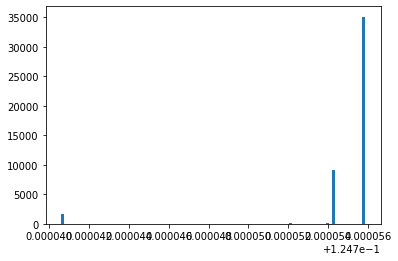

In [37]:
goodsData_moreExtremes = goodsData.copy()
goodsData_moreExtremes['extremeHeat']   += 10
goodsData_moreExtremes['extremePrecip'] += 10

ypred_moreExtremes = tempMod.predict(goodsData_moreExtremes)

plt.hist(ypred_moreExtremes - ypred, bins = 100)



# Indirect Effects
Let's look at the effects on a customer of extremes at its suppliers.

In [27]:
goodsData = pd.read_csv("../../data/companyData/goodsData_largestSupplierData_indirEffects.csv").drop(columns = {'Unnamed: 0'})
goodsData.head()


,year,supplier_gvkey,gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,...,firmQtr,ageQtr,sizeQtr,profitQtr,indQtr,supplier_extremeHeat,supplier_heat90Plus,supplier_extremePrecip,supplierTempTercile,supplierPrecipTercile
0,2001,147639,1045,95.476,2003-01-01,2008-01-01,transportUtilities,transportUtilities,american airlines,american airlines,...,1045_1,1_2001_1,3_2001_1,2_2001_1,transportUtilities2001_1,6,0,5,1,2
1,2001,147639,1382,33.209,2003-01-01,2015-01-01,transportUtilities,transportUtilities,us airways,us airways,...,1382_1,2_2001_1,2_2001_1,2_2001_1,transportUtilities2001_1,6,0,5,1,2
2,2001,147639,10484,37.851,2004-01-01,2011-01-01,transportUtilities,transportUtilities,united airlines,united service,...,10484_1,2_2001_1,2_2001_1,2_2001_1,transportUtilities2001_1,6,0,5,1,2
3,2001,147639,10946,166.047,2003-01-01,2003-01-01,transportUtilities,transportUtilities,us airways,us airways,...,10946_1,1_2001_1,2_2001_1,2_2001_1,transportUtilities2001_1,6,0,5,1,2
4,2001,147639,1045,95.476,2003-01-01,2008-01-01,transportUtilities,transportUtilities,american airlines,american airlines,...,1045_2,1_2001_2,3_2001_2,2_2001_2,transportUtilities2001_2,4,1,7,2,3


In [28]:
allWeather_withLags = pd.read_csv("../../data/companyData/allWeather_withLags_allZips.csv").drop(columns = {'Unnamed: 0'})


In [29]:
goodsData.shape

(31446, 242)

In [30]:
np.sum(goodsData.dist > 250)/goodsData.shape[0]

0.7901481905488774

In [31]:
# goodsData = pd.read_csv("../../data/companyData/goodsData_supplierData.csv").drop(columns = {'Unnamed: 0'})
goodsData['year']      = goodsData.year.astype('str').str.slice(0,4).astype('int64')
goodsData['firstYear'] = goodsData.firstYear.astype('str').str.slice(0,4).astype('int64')
goodsData['lastYear']  = goodsData.lastYear.astype('str').str.slice(0,4).astype('int64')


goodsData.columns = goodsData.columns.str.replace("0.95", "Extreme")

print(goodsData.shape, goodsData.columns)

firms = goodsData['gvkey']

(31446, 242) Index(['year', 'supplier_gvkey', 'gvkey', 'salecs', 'firstYear', 'lastYear',
       'customer_ind', 'supplier_ind', 'customer_cstatCompanies',
       'customer_igCompanies',
       ...
       'firmQtr', 'ageQtr', 'sizeQtr', 'profitQtr', 'indQtr',
       'supplier_extremeHeat', 'supplier_heat90Plus', 'supplier_extremePrecip',
       'supplierTempTercile', 'supplierPrecipTercile'],
      dtype='object', length=242)


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [32]:
for col in goodsData.columns:
    print(col)

year
supplier_gvkey
gvkey
salecs
firstYear
lastYear
customer_ind
supplier_ind
customer_cstatCompanies
customer_igCompanies
customer_abi
supplier_cstatCompanies
supplier_igCompanies
supplier_abi
customer_latitude
customer_longitude
customer_zipcode
supplier_latitude
supplier_longitude
supplier_zipcode
dist
totalSuppliers
meanSales
qtr
companyName
curcdq
assets
cash
costGoodsSold
totalInv
netIncome
opInc_afDep
opInc_befDep
totalRevenue
costat
priceClose
add1
addzip
city
state
assetsLast
netIncomeLast
totalRevenueLast
costGoodsSoldLast
totalInvLast
opInc_afDepLast
opInc_befDepLast
priceCloseLast
cashLast
fyearq
assetsLagged
netIncomeLagged
roa_lagged
sic2
indGroup
earliestYear
ageTercile
sizeTercile
profitTercile
datacqtr
datafqtr
fyr
DATE
supplier_precip_annual_50
supplier_precip_annual_95
supplier_precip_annual_99
supplier_precip_zip_50
supplier_precip_zip_95
supplier_precip_zip_99
supplier_precip_zipQuarter_50
supplier_precip_zipQuarter_95
supplier_precip_zipQuarter_99
supplier_temp_an

In [33]:
goodsData['supplierConc'] = goodsData['dist'] > 100

In [34]:
start = time.time()


outcome  = 'lnRevNormd'
weather  = 'supplier_extremePrecip'#*C(supplierConc)'
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

precipModIndir = smf.ols(formula = equation, data = goodsData[goodsData.dist < 250]).fit()

print(time.time() - start) 


print(precipModIndir.summary())

lnRevNormd ~ supplier_extremePrecip + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
1.0877931118011475
                            OLS Regression Results                            
Dep. Variable:             lnRevNormd   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     70.47
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:56:52   Log-Likelihood:                -3342.2
No. Observations:                6485   AIC:                             7414.
Df Residuals:                    6120   BIC:                             9888.
Df Model:                         364                                         
Covariance Type:            nonrobust                                         
                                                  coef    

In [35]:
start = time.time()

# outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

outcome  = 'lnOpIncNormd'
weather  = 'supplier_extremePrecip '
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

precipModIndir = smf.ols(formula = equation, data = goodsData).fit()

print(time.time() - start) 


print(precipModIndir.summary())

lnOpIncNormd ~ supplier_extremePrecip  + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
12.117975234985352
                            OLS Regression Results                            
Dep. Variable:           lnOpIncNormd   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     38.00
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:03:40   Log-Likelihood:                -2410.2
No. Observations:               31272   AIC:                             6726.
Df Residuals:                   30319   BIC:                         1.468e+04
Df Model:                         952                                         
Covariance Type:            nonrobust                                         
                                                  coef 

In [178]:
precipAvg = pd.read_csv("../../data/companyData/precipExtraDays.csv").\
    drop(columns = {'Unnamed: 0'}).rename(columns = {'zipcode': 'supplier_zipcode'})


precipAvg.head()

,variable,supplier_zipcode,Q1,Q2,Q3,Q4
0,pr_hist,1226,0.928571,-0.119048,1.785714,0.547619
1,pr_hist,1434,0.976190,-0.023810,2.023810,1.880952
2,pr_hist,1460,0.976190,-0.023810,2.119048,1.976190
3,pr_hist,1473,0.976190,-0.023810,2.119048,1.976190
4,pr_hist,1507,0.976190,-0.023810,2.023810,1.880952


In [179]:
precipPreds = goodsData.merge(precipAvg)

precipPreds.loc[precipPreds['qtr'] == 1, 'extremePrecip'] = precipPreds.Q1 + precipPreds.Q4
precipPreds.loc[precipPreds['qtr'] == 2, 'extremePrecip'] = precipPreds.Q2 + precipPreds.Q1
precipPreds.loc[precipPreds['qtr'] == 3, 'extremePrecip'] = precipPreds.Q3 + precipPreds.Q2
precipPreds.loc[precipPreds['qtr'] == 4, 'extremePrecip'] = precipPreds.Q4 + precipPreds.Q3
# precipPreds['extremePrecip'] = 

In [180]:
precipPreds.extremePrecip.describe()

count    31446.000000
mean         0.407420
std          1.403588
min         -3.190476
25%         -0.476190
50%          0.476190
75%          1.333333
max          4.190476
Name: extremePrecip, dtype: float64

In [181]:
 precipModIndir.params.supplier_extremePrecip

-0.0011924276629196855

In [183]:
precipPreds['changes'].describe()

count    31446.000000
mean        -0.000486
std          0.001674
min         -0.004997
25%         -0.001590
50%         -0.000568
75%          0.000568
max          0.003804
Name: changes, dtype: float64

In [184]:
precipPreds['changes'] = precipModIndir.params.supplier_extremePrecip*precipPreds.extremePrecip


In [185]:
stateChangesIndir = pd.DataFrame(precipPreds['changes'].groupby(precipPreds.state).mean().reset_index())
stateChangesIndir.rename(columns = {'changes': 'indirChanges'}, inplace = True)

stateChangesIndir.head()

,state,indirChanges
0,AL,0.000757
1,AR,-0.000952
2,AZ,-0.000467
3,CA,-0.000306
4,CO,-0.000334


In [193]:
stateChangesIndir.indirChanges.˜stadescribe()

count    45.000000
mean     -0.000524
std       0.000619
min      -0.001847
25%      -0.000857
50%      -0.000550
75%      -0.000338
max       0.001150
Name: indirChanges, dtype: float64

In [221]:
allEffects = dirEffects.merge(stateChangesIndir)

allEffects.sort_values(by = ['changes'], inplace = True)

In [222]:
allEffects.head()

,state,changes,indirChanges
16,MA,-0.047620,-0.000690
24,NH,-0.045911,-0.001847
0,AL,-0.033876,0.000757
22,NC,-0.033701,-0.000471
7,DE,-0.032862,-0.000636


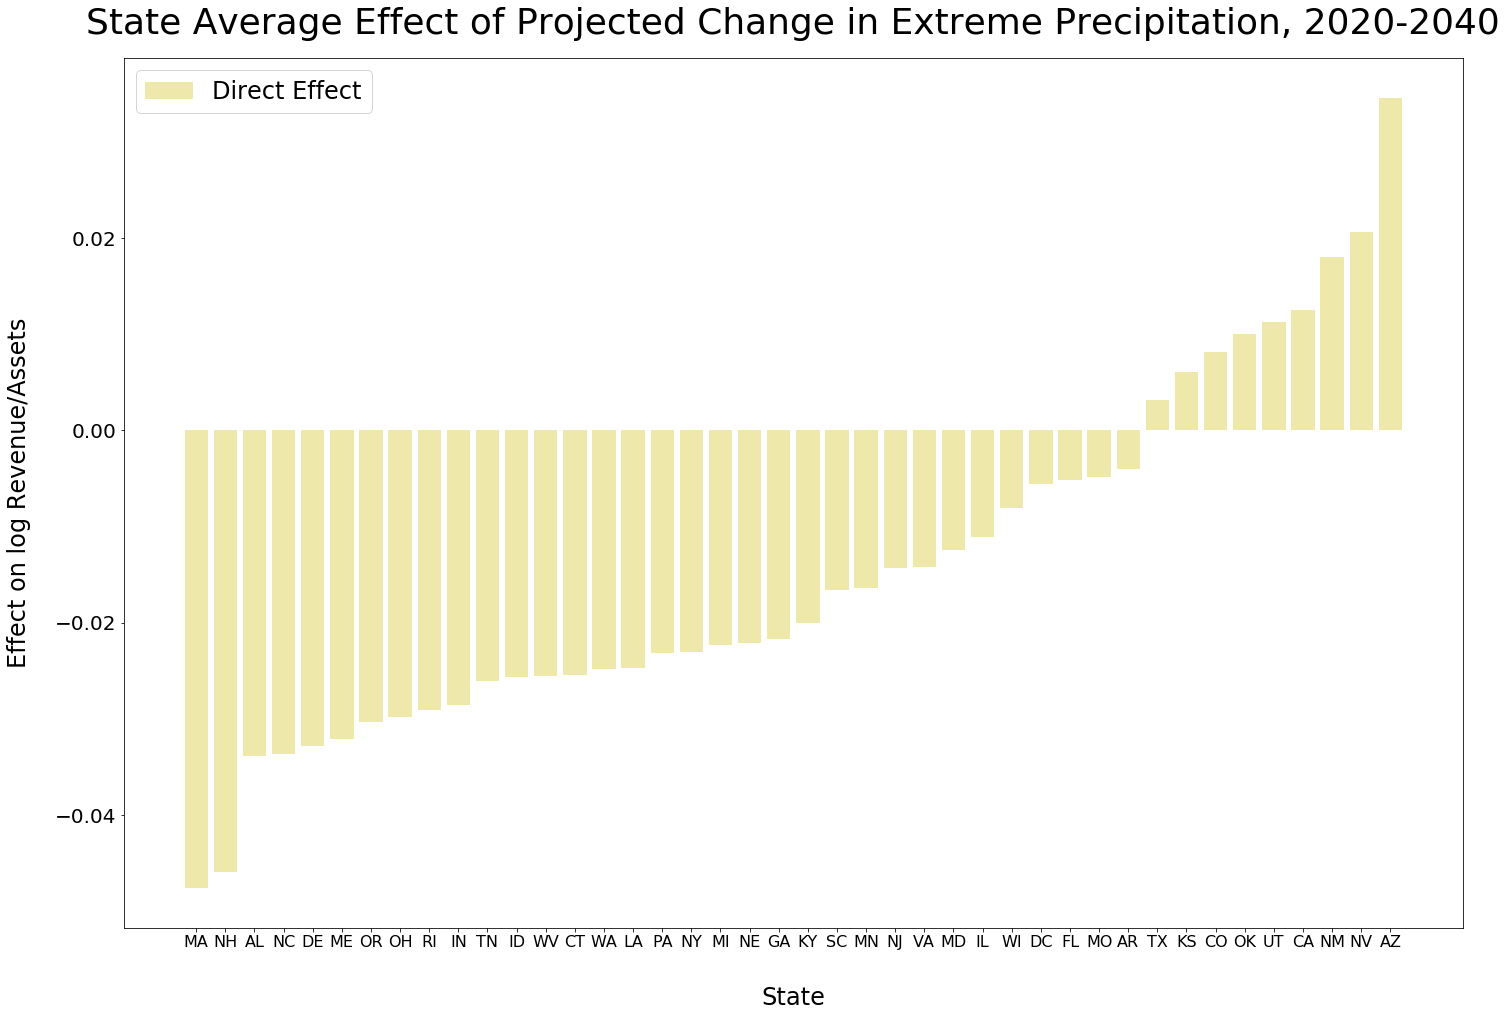

In [258]:
plt.figure(figsize = (24, 16))


plt.bar(allEffects.state,allEffects.changes,      
        label = 'Direct Effect',   color = 'palegoldenrod')
'''plt.bar(allEffects.state,allEffects.indirChanges, 
        label = 'Indirect Effect', color = 'firebrick')'''

plt.title('State Average Effect of Projected Change in Extreme Precipitation, 2020-2040',
          fontsize = 36, pad = 24)

plt.xlabel('State', fontsize = 24, labelpad = 36)
plt.xticks(fontsize=16)

plt.ylabel('Effect on log Revenue/Assets', fontsize = 24, labelpad = 24)
plt.yticks(fontsize=20)

plt.legend(fontsize = 24, loc = 'upper left')
plt.show()

We see the same thing here with temperature: positive correlation overall, with a negative effect on the warmer terciles and a positive effect on the coolest one.

In [131]:
start = time.time()

# outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']


outcome  = 'lnOpIncNormd'
weather  = 'supplier_heat90Plus'
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

tempMod = smf.ols(formula = equation, data = goodsData).fit()

print(time.time() - start) 


print(tempMod.summary())

lnOpIncNormd ~ supplier_heat90Plus + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
11.963567018508911
                            OLS Regression Results                            
Dep. Variable:           lnOpIncNormd   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     37.58
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:19:58   Log-Likelihood:                -73683.
No. Observations:               31272   AIC:                         1.493e+05
Df Residuals:                   30319   BIC:                         1.572e+05
Df Model:                         952                                         
Covariance Type:            nonrobust                                         
                                                  coef    s

In [20]:
start = time.time()

outcome  = 'lnOpIncNormd'
weather  = 'C(supplierTempTercile)*(supplier_heat90Plus)'
controls = 'C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

equation = outcome + ' ~ ' + weather + ' + ' + controls
 
print(equation)

tempMod = smf.ols(formula = equation, data = goodsData).fit()

print(time.time() - start) 


print(tempMod.summary())

lnOpIncNormd ~ C(supplierTempTercile)*(supplier_heat90Plus) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
12.665775775909424
                            OLS Regression Results                            
Dep. Variable:           lnOpIncNormd   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     37.84
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:21:16   Log-Likelihood:                -2410.5
No. Observations:               31272   AIC:                             6735.
Df Residuals:                   30315   BIC:                         1.473e+04
Df Model:                         956                                         
Covariance Type:            nonrobust                                         
                                  

Let's do the same as we did below, making a dataframe that summarizes a lot of the results. For now just do: 
- extreme heat
- extreme precip
- both of above, with breakdown by tercile

In [23]:
resultList = []
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['supplier_extremePrecip',
               'supplier_extremeHeat',
               'supplier_heat90Plus'
              ]


# 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
# 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
# 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

controls = 'C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)'

for weatherVar in weatherVars:
    print("***************")
    print(weatherVar)
    results = pd.DataFrame()

    for outcome in outcomes:            
        equation = outcome + ' ~ ' + weatherVar + ' + ' + controls
        print(equation)
        
        try:
            mod = smf.ols(formula = equation, data = goodsData).fit()             

            print(time.time() - start) 

            # convert this into a much more condensed version
            coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

            coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass

    resultList.append(results)


allResults = pd.concat(resultList, axis=0)


***************
supplier_extremePrecip
lnOpIncNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
10.55065107345581
                               coeffs      pvals
supplier_extremePrecip       -0.00097   0.002604
upperVariable           ^lnOpIncNormd  *********
lnRevNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
21.316709995269775
                             coeffs      pvals
supplier_extremePrecip    -0.001237   0.010753
upperVariable           ^lnRevNormd  *********
lnCostNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
32.02339792251587
                              coeffs      pvals
supplier_extremePrecip     -0.000072   0.908139
upperVariable           ^lnCostNormd  *********
lnStockClose ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey)
42.44922208786011
                               coeffs      pvals
supplier_extremePrecip      -0.001659   0.005894
upperVariable           ^lnSt

In [21]:
resultList = []
start = time.time()


outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

weatherVars = ['supplier_extremePrecip',
               'supplier_extremeHeat',
               'supplier_heat90Plus',
               'supplier_streak90Plus',
               'supplier_extremePrecip*C(supplierPrecipTercile)',
               'supplier_extremeHeat*C(supplierTempTercile)',
               'supplier_heat90Plus*C(supplierTempTercile)',
               'supplier_streak90Plus*C(supplierTempTercile)'
              ]


# 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
# 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
# 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

controls = 'C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

for weatherVar in weatherVars:
    print("***************")
    print(weatherVar)
    results = pd.DataFrame()

    for outcome in outcomes:            
        equation = outcome + ' ~ ' + weatherVar + ' + ' + controls
        print(equation)
        
        try:
            mod = smf.ols(formula = equation, data = goodsData).fit()             

            print(time.time() - start) 

            # convert this into a much more condensed version
            coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
            pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

            coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
            pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

            resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

            resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

            results = pd.concat([results,resultsTemp], axis = 1)

            print(resultsTemp)
        except:
            print('No Dice! ' + outcome + "~" + weatherVar)
            pass

    resultList.append(results)


allResults = pd.concat(resultList, axis=0)


***************
supplier_extremePrecip
lnOpIncNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
12.308876991271973
                               coeffs      pvals
supplier_extremePrecip      -0.000929   0.003705
upperVariable           ^lnOpIncNormd  *********
lnRevNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
24.381559133529663
                             coeffs      pvals
supplier_extremePrecip    -0.001177   0.012841
upperVariable           ^lnRevNormd  *********
lnCostNormd ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
37.71252918243408
                              coeffs      pvals
supplier_extremePrecip     -0.000032   0.958381
upperVariable           ^lnCostNormd  *********
lnStockClose ~ supplier_extremePrecip + C(indGroup)*C(qtr) + C(yearQtr)

255.54928517341614
                                                       coeffs      pvals
C(supplierTempTercile)[T.2]                          0.028987   0.023556
C(supplierTempTercile)[T.3]                          0.018905   0.217942
supplier_extremeHeat                                 0.000779   0.264861
supplier_extremeHeat:C(supplierTempTercile)[T.2]    -0.000625   0.476897
supplier_extremeHeat:C(supplierTempTercile)[T.3]    -0.001033   0.202316
upperVariable                                     ^lnRevNormd  *********
lnCostNormd ~ supplier_extremeHeat*C(supplierTempTercile) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)
267.3470849990845
                                                        coeffs      pvals
C(supplierTempTercile)[T.2]                           0.026715   0.109242
C(supplierTempTercile)[T.3]                           0.016512   0.408675
supplier_extremeHeat                                 -0.000423   0.641868
s

# Direct Effects
Look at the effects on the suppliers when they're affected directly.

## Complete Dataset
### At HQs

The below gives us the full, clustered standard errors.

In [54]:
resultList[0]

,coeffs,pvals,conc
precip_zipQuarterquant_Extreme,-0.013955,0.001611,_more25%
lag1_precip_zipQuarterquant_Extreme,-0.009473,0.032546,_more25%
lag2_precip_zipQuarterquant_Extreme,-0.003884,0.379477,_more25%
lag3_precip_zipQuarterquant_Extreme,-0.005953,0.178952,_more25%
upperVariable,^lnOpIncNormd,*********,_more25%


First, do the basics: days of extreme precipitation and (separately) extreme temperature, with 3 lags. We include a balance of time and industry-specific controls, fewer than are in the other regressions but generally allowing for a time trend, firm-specific trends, industry-seasonal trends, and profit, size, and age characteristics. We don't have time-specific trends across firms or industries but it's not clear that these would really change over the 10 years of the sample.



There are a couple of background facts that I'm relying on here: 
- the 1x year, 1x5 years, etc variables might be too rare to really pick up an effect.
- it's possible that lower tiers, or less extreme extremes, might matter too. may want to try to pick up a lower threshold as well. 
- the normalized variables (divided by lagged assets) seem to be more sensitive / response than just growth and just log-levels. this is likely because of something like the fact that this helps equalize for differences in the size of the firms in a way that neither log nor growth does. 



there are a couple of things to remember with these results:
- the company size/age/profitability terciles don't make a lick of difference
- precipitation seems to matter, period, for cumulative number of days
- temperature might need a longer streak for the effect to happen



a few things come out more in the heterogeneity analyses:
- it seems like the local-relative extremes matter especially at the upper ends of the distributions. this is a little counterintuitive but i think the story is something like the following: we expect that places with higher average temperatures would have higher ''95th percentile events'', and places with lower average temperatures might have lower ''95th percentile events'', that might actually not be that extreme. 
- we would expect the heatBin:extremeTemp(Precip) measure to show an opposite result if the extreme definition is an absolute one and not a relative one (larger effect in places with lower normal temps (precip) // lower effect in places with higher normal temps (precip)) because it's closer to their baseline & closer to what they might expect.
- there's not much with the industry-specific results? it could be that the data are currently too diffuse or too small to really 



questions:
- are there other moments of distributions or other ways to measure shifts in extremes?
- how should i best approach the industry-specific regressions? - separate regressions or interaction terms?
- what mechanisms should i consider? bs consider the role of "input specificity", as judged by patents or r&d. ps consider a few different ones: materiality, defined by value of physical assets/value of total assets; industry specificity; and expectation. 
    - are there any "climate mechanisms" i can examine here, other than just expectations?
    - how can we adapt or incorporate the scc here?



things to push forward on:
- targeting specific industries: either with different lag tiers, or with 
- indirect regressions!
- stock regressions
- extreme convective storms
- counts in disclosures



things that are probably very relevant that i should keep experimenting with:
- measures of concentration: establishment weights, percent of firm w/in 10% (or honestly 70%+) of hq
- extreme temp as 90+, maybe some flood-relative measure of extreme rain?


First, total days of heat and rain.



*AT SOME POINT, WE CAN ADD ADDTL COLUMNS FOR OTHER VARIABLES OF INTEREST TO THIS AS WELL: cost & profit, maybe also stocks [if we do a quarter before, quarter after] thing

In [ ]:
resultList = []

keys = ['_more25%', '_more50%', '_more75%', '']

start = time.time()


for key in keys:
    '##################################################################'
    filename = '../../data/companyData/goodsData_igData' + key + '.csv'
    
    print(filename)

    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})

    goodsData.columns = goodsData.columns.str.replace("0.95", "Extreme")

    print(goodsData.shape)

    firms = goodsData['gvkey']



    outcomes = ['lnOpIncNormd', 'lnRevNormd', 'lnCostNormd', 'lnStockClose']

    weatherVars = ['precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme',
                  'temp5Days_zipQuarterquant_Extreme + lag1_temp5Days_zipQuarterquant_Extreme + lag2_temp5Days_zipQuarterquant_Extreme + lag3_temp5Days_zipQuarterquant_Extreme',
                  'days90Plus + lag1_days90Plus + lag2_days90Plus + lag3_days90Plus',
                  'streak90Plus + lag1_streak90Plus + lag2_streak90Plus + lag3_streak90Plus', 
                  'propAboveTenThou + lag1_propAboveTenThou + lag2_propAboveTenThou + lag3_propAboveTenThou',
                  'propAboveHundredThou + lag1_propAboveHundredThou + lag2_propAboveHundredThou + lag3_propAboveHundredThou',
                  'propAboveMilli + lag1_propAboveMilli + lag2_propAboveMilli + lag3_propAboveMilli']

                  # 'temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ', 
                  # 'temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ',
                  # 'temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ']

    controls = ' + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)'

    for weatherVar in weatherVars:
        print("***************")
        results = pd.DataFrame()

        for outcome in outcomes:    
            print(outcome + "~" + weatherVar)
            try:
                mod = smf.ols(formula = outcome + ' ~ ' + weatherVar + controls, data = goodsData).fit()             

                print(time.time() - start) 

                # convert this into a much more condensed version
                coeffs = pd.DataFrame(mod.params,   columns = ['coeffs'])
                pvalues = pd.DataFrame(mod.pvalues, columns = ['pvals'])

                coeffs = coeffs[coeffs.index.str.contains(weatherVar[0:4])]
                pvalues = pvalues[pvalues.index.str.contains(weatherVar[0:4])]

                resultsTemp = pd.concat([coeffs,pvalues],axis = 1)

                resultsTemp.loc['upperVariable'] = ['^' + outcome, '*********'] 

                results = pd.concat([results,resultsTemp], axis = 1)
                results['conc'] = key

                print(resultsTemp)
                
            except:
                print('No Dice! ' + outcome + "~" + weatherVar)
                pass

        resultList.append(results)
        
        
allResults = pd.concat(resultList, axis=0)

allResults.to_csv('../../data/companyData/results.csv')


../../data/companyData/goodsData_igData_more25%.csv


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


(37942, 892)
***************
lnOpIncNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
No Dice! lnOpIncNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
lnRevNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
No Dice! lnRevNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
lnCostNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
No Dice! lnCostNormd~precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme
ln

In [12]:
allResults = pd.DataFrame()

for result in resultList:
    if result.shape[1] == 9:
        allResults = pd.concat([allResults,result])
    print(allResults)

                                            coeffs      pvals      conc  \
precip_zipQuarterquant_Extreme           -0.013955   0.001611  _more25%   
lag1_precip_zipQuarterquant_Extreme      -0.009473   0.032546  _more25%   
lag2_precip_zipQuarterquant_Extreme      -0.003884   0.379477  _more25%   
lag3_precip_zipQuarterquant_Extreme      -0.005953   0.178952  _more25%   
upperVariable                        ^lnOpIncNormd  *********  _more25%   

                                          coeffs      pvals        coeffs  \
precip_zipQuarterquant_Extreme          -0.00132    0.17013      -0.00058   
lag1_precip_zipQuarterquant_Extreme    -0.000822   0.394243     -0.000487   
lag2_precip_zipQuarterquant_Extreme    -0.001947   0.043086     -0.002664   
lag3_precip_zipQuarterquant_Extreme    -0.003343   0.000533     -0.003296   
upperVariable                        ^lnRevNormd  *********  ^lnCostNormd   

                                         pvals         coeffs      pvals  
precip_zipQ

In [14]:
allResults.to_csv('../../data/companyData/allResults_byConc.csv')

Try to get the variance-covariance matrix, from https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.cov_params.html . We can use this in the calculation of MEs.

In [ ]:
precipMod.cov_params()

In [ ]:
start = time.time()

# + C(ageTercile) + C(profitTercile) + C(sizeTercile)
tempMod = smf.ols(formula = 'lnRevNormd ~ temp_zipQuarterquant_Extreme + lag1_temp_zipQuarterquant_Extreme + lag2_temp_zipQuarterquant_Extreme + lag3_temp_zipQuarterquant_Extreme + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) ', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs = pd.DataFrame(tempMod.params,   columns = ['coeffs'])
pvalues = pd.DataFrame(tempMod.pvalues, columns = ['pvals'])

coeffs = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)


These results are influenced by the particular transformation. if we do 1 + the ratio, we have a particular problem with the second period here.

Look at "sustained" heat and rain. We can look at incidence of a heatwave or sustained temperatures above a given amount.

In [ ]:
start = time.time()


precip5DaysMod = smf.ols(formula = 'lnRevNormd ~ precip5Days_zipQuarterquant_Extreme + lag1_precip5Days_zipQuarterquant_Extreme + lag2_precip5Days_zipQuarterquant_Extreme + lag3_precip5Days_zipQuarterquant_Extreme + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs = pd.DataFrame(precip5DaysMod.params,   columns = ['coeffs'])
pvalues = pd.DataFrame(precip5DaysMod.pvalues, columns = ['pvals'])

coeffs = coeffs[coeffs.index.str.contains('precip')]
pvalues = pvalues[pvalues.index.str.contains('precip')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)


In [ ]:
start = time.time()


temp5DaysMod = smf.ols(formula = 'lnRevNormd ~ temp5Days_zipQuarterquant_Extreme + lag1_temp5Days_zipQuarterquant_Extreme + lag2_temp5Days_zipQuarterquant_Extreme + lag3_temp5Days_zipQuarterquant_Extreme + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(temp5DaysMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(temp5DaysMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)


## Breakouts by tercile

See how the effect varies in places that are background hot // background wet.

Sort of inspired by the BS2016 tercile approach, we divide each place into terciles. I THINK (double check this) that this is based on annual average temperature and precipitation. 



In [ ]:
start = time.time()


precipModTercile = smf.ols(formula = 'lnRevNormd ~ C(precipTercile)*(precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(precipModTercile.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(precipModTercile.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('precip')]
pvalues = pvalues[pvalues.index.str.contains('precip')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempModTercile = smf.ols(formula = 'lnRevNormd ~ C(tempTercile)*(temp_zipQuarterquant_Extreme + lag1_temp_zipQuarterquant_Extreme + lag2_temp_zipQuarterquant_Extreme + lag3_temp_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(tempModTercile.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempModTercile.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Now try the sustained effects.

In [ ]:
start = time.time()


precip5DaysModTercile = smf.ols(formula = 'lnRevNormd ~ C(precipTercile)*(precip5Days_zipQuarterquant_Extreme + lag1_precip5Days_zipQuarterquant_Extreme + lag2_precip5Days_zipQuarterquant_Extreme + lag3_precip5Days_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(precip5DaysModTercile.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(precip5DaysModTercile.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('precip')]
pvalues = pvalues[pvalues.index.str.contains('precip')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


temp5DaysModTercile = smf.ols(formula = 'lnRevNormd ~ C(tempTercile)*(temp5Days_zipQuarterquant_Extreme + lag1_temp5Days_zipQuarterquant_Extreme + lag2_temp5Days_zipQuarterquant_Extreme + lag3_temp5Days_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(temp5DaysModTercile.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(temp5DaysModTercile.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)


# Temperature
It seems like we're getting a pretty strong signal on precipitation: more precipitation is bad, and it's bad even (especially?) in places where background level of precipitation is high, maybe because the most extreme tail of it is that much more extreme in these places. We have a little bit more work to do with temperature. 

From the above, we find the following:
    - Temperature does NOT seem to matter on a 1-day fluctuation basis. 
    - Temperature DOES seem to matter on a 5-day moving average case.
    
We can seem to look at the following:
    - Total days above 90F (another extreme; maybe interact with quartiles of avg temperature too)
    - Y/N for whether there was a 7-day streak above 90F, matching PS.
    - Weeks, months, qtr at different t'hold
        - Maybe try different bins as well.


First, try the total number of days that are at least 90F. Weird result is that more days above 90 is associated with better results here. REVISIT THIS.

In [ ]:
start = time.time()


tempDaysAbove90Mod = smf.ols(formula = 'lnRevNormd ~ days90Plus + lag1_days90Plus + lag2_days90Plus + lag3_days90Plus + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

# convert this into a much more condensed version
coeffs  = pd.DataFrame(tempDaysAbove90Mod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempDaysAbove90Mod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('days90')]
pvalues = pvalues[pvalues.index.str.contains('days90')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

If we look at the breakdown by days that are normally below, at, or above average, we see the strongest result is in places that are normally below average. This is a drop of almost 4\%.

In [ ]:
start = time.time()


tempDaysAbove90Mod = smf.ols(formula = 'lnRevNormd ~ C(tempTercile)*(days90Plus + lag1_days90Plus + lag2_days90Plus + lag3_days90Plus) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempDaysAbove90Mod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempDaysAbove90Mod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('days90')]
pvalues = pvalues[pvalues.index.str.contains('days90')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Now let's try the same things by streaks. The effect sizes are large, but not statistically significantly estimated.

In [ ]:
start = time.time()


tempStreakAbove90Mod = smf.ols(formula = 'lnRevNormd ~ streak90Plus + lag1_streak90Plus + lag2_streak90Plus + lag3_streak90Plus + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempStreakAbove90Mod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempStreakAbove90Mod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('streak90')]
pvalues = pvalues[pvalues.index.str.contains('streak90')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempStreakAbove90Mod_intxn = smf.ols(formula = 'lnRevNormd ~  C(tempTercile)*(streak90Plus + lag1_streak90Plus + lag2_streak90Plus + lag3_streak90Plus) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempStreakAbove90Mod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempStreakAbove90Mod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('streak90')]
pvalues = pvalues[pvalues.index.str.contains('streak90')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Let's try the things by weeks, month, quarter.

In [ ]:
start = time.time()

#  + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 + lag3_temp_zipWeek95_99
# 

tempWeekMod = smf.ols(formula = 'lnRevNormd ~  (temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempWeekMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempWeekMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

If we break this down by the background temperature of the place, though, it seems like we find a similar effect in the coldest places: a warm week in the coldest places is the most negative, in the quarter concurrent with when it's warmest.


[is this the same effect? other places, did we not see a positive effect of slightly warmer weather in cooler places?]

In [ ]:
start = time.time()

#  + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 + lag3_temp_zipWeek95_99
# + C(ageTercile) + C(profitTercile) + C(sizeTercile)

tempWeekMod_intxn = smf.ols(formula = 'lnRevNormd ~  C(tempTercile)*(temp_zipWeek95_99 + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile) ', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempWeekMod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempWeekMod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Try months now.

In [ ]:
start = time.time()

#  + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 + lag3_temp_zipMonth95_99
# 

tempMonthMod = smf.ols(formula = 'lnRevNormd ~  (temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempMonthMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempMonthMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()

#  + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 + lag3_temp_zipMonth95_99
# + C(ageTercile) + C(profitTercile) + C(sizeTercile)

tempMonthMod_intxn = smf.ols(formula = 'lnRevNormd ~  C(tempTercile)*(temp_zipMonth95_99 + lag1_temp_zipMonth95_99 + lag2_temp_zipMonth95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile) ', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempMonthMod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempMonthMod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

And quarters.

In [ ]:
start = time.time()

#  + lag1_temp_zipWeek95_99 + lag2_temp_zipWeek95_99 + lag3_temp_zipWeek95_99
# + C(ageTercile) + C(profitTercile) + C(sizeTercile)

tempQuarterMod = smf.ols(formula = 'lnRevNormd ~  (temp_zipQuarter95_99 + lag1_temp_zipQuarter95_99 + lag2_temp_zipQuarter95_99 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile) ', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempQuarterMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempQuarterMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempQuarterMod_intxn = smf.ols(formula = 'lnRevNormd ~  C(tempTercile)*(temp_zipQuarter90_95 + lag1_temp_zipQuarter90_95 + lag2_temp_zipQuarter90_95 ) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile) ', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempQuarterMod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempQuarterMod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('temp')]
pvalues = pvalues[pvalues.index.str.contains('temp')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

## Additional Tests
Now try a few other ones here. 
- Streak of days above 95th percentile, temperature and rain.
- By categories of days: 0-5, 5-10, 10-15, 15+

In [ ]:
start = time.time()


precipStreakMod = smf.ols(formula   = 'lnRevNormd ~ C(wetStreak) + C(lag1_wetStreak) + C(lag2_wetStreak) + C(lag3_wetStreak) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()


print(time.time() - start) 

coeffs  = pd.DataFrame(precipStreakMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(precipStreakMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('wet')]
pvalues = pvalues[pvalues.index.str.contains('wet')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempStreakMod = smf.ols(formula   = 'lnRevNormd ~ C(hotStreak) + C(lag1_hotStreak) + C(lag2_hotStreak) + C(lag3_hotStreak) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()

print(time.time() - start) 

coeffs  = pd.DataFrame(tempStreakMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempStreakMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('hot')]
pvalues = pvalues[pvalues.index.str.contains('hot')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

Try with the different breakout categories of what's coming together.

In [ ]:
start = time.time()


precipCatMod = smf.ols(formula   = 'lnRevNormd ~ C(wetDaysCat) + C(lag1_wetDaysCat) + C(lag2_wetDaysCat) + C(lag3_wetDaysCat) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

coeffs  = pd.DataFrame(precipCatMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(precipCatMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('wet')]
pvalues = pvalues[pvalues.index.str.contains('wet')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempCatMod = smf.ols(formula   = 'lnRevNormd ~ C(hotDaysCat) + C(lag1_hotDaysCat) + C(lag2_hotDaysCat) + C(lag3_hotDaysCat) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()


print(time.time() - start) 


coeffs  = pd.DataFrame(tempCatMod.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempCatMod.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('hot')]
pvalues = pvalues[pvalues.index.str.contains('hot')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

In [ ]:
start = time.time()


tempCatMod_intxn = smf.ols(formula   = 'lnRevNormd ~ C(tempTercile)*(C(hotDaysCat) + C(lag1_hotDaysCat) + C(lag2_hotDaysCat) + C(lag3_hotDaysCat)) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()


print(time.time() - start) 


coeffs  = pd.DataFrame(tempCatMod_intxn.params,  columns = ['coeffs'])
pvalues = pd.DataFrame(tempCatMod_intxn.pvalues, columns = ['pvals'])

coeffs  = coeffs[coeffs.index.str.contains('hot')]
pvalues = pvalues[pvalues.index.str.contains('hot')]

results = pd.concat([coeffs,pvalues],axis = 1)


print(results)

# Robustness Checks
Try playing with temperature a little bit more. Look at:
    - interaction with concentration
    - establishment-weighted vars

In [ ]:
start = time.time()


tempStreakConcMod = smf.ols(formula   = 'lnRevNormd ~ C(firmConcTercile)*(C(hotDaysCat) + C(lag1_hotDaysCat) + C(lag2_hotDaysCat) + C(lag3_hotDaysCat)) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)
tempStreakConcRes = tempStreakConcMod.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

tempStreakConcRes.summary()

Try the temperature as defined by super super hot days, anywhere in the country - 95th percentile anywhere. This will only happen in a few places in , or at least, there will be some geographic skew. But we can control for that by looking at the effect of hot temps given different baselines.

In [ ]:
start = time.time()


tempModAnnual_noControls = smf.ols(formula   = 'lnRevNormd ~ temp_annualquant_Extreme + lag1_temp_annualquant_Extreme + lag2_temp_annualquant_Extreme + lag3_temp_annualquant_Extreme + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey)', data = goodsData)
tempResAnnual_noControls = tempModAnnual_noControls.fit(cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

tempResAnnual_noControls.summary()


Let's try the standard interactions, controlling for the background climate in given places.

If we look at the below, we see that the places that are normally coolest are negatively impacted by extreme extremes. Specifically, using an across-the-country cutoff for temperature, we have that the biggest negative effect happens in the places that are normally the lowest-temperature.

This gives some promise that we might find an effect of temperature in some places, depending on expectation or baseline climate.

In [ ]:
start = time.time()


tempEstMod_annual = smf.ols(formula   = 'lnRevNormd ~ C(tempTercile)*(temp_annualquant_Extreme + lag1_temp_annualquant_Extreme + lag2_temp_annualquant_Extreme + lag3_temp_annualquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)


tempResMod_annual = tempEstMod_annual.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

tempResMod_annual.summary()

Let's try it by precipitation quartile for comparison's sake.

In [ ]:
start = time.time()


precipEstMod_annual = smf.ols(formula   = 'lnRevNormd ~ C(precipTercile)*(precip_annualquant_Extreme + lag1_precip_annualquant_Extreme + lag2_precip_annualquant_Extreme + lag3_precip_annualquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)


precipResMod_annual = precipEstMod_annual.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

precipResMod_annual.summary()

Now let's make sure we have the originals, the OGs, for comparison.

In [ ]:
start = time.time()


tempEstMod_zipQuarter = smf.ols(formula   = 'lnRevNormd ~ C(tempTercile)*(temp_zipQuarterquant_Extreme + lag1_temp_zipQuarterquant_Extreme + lag2_temp_zipQuarterquant_Extreme + lag3_temp_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)


tempResMod_zipQuarter = tempEstMod_zipQuarter.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

tempResMod_zipQuarter.summary()

In [ ]:
start = time.time()


precipEstMod_zipQuarter = smf.ols(formula   = 'lnRevNormd ~ C(precipTercile)*(precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', 
                           data = goodsData)


precipResMod_zipQuarter = precipEstMod_zipQuarter.fit() # cov_type  = 'cluster',cov_kwds={'groups': firms},use_t=True)


print(time.time() - start) 

precipResMod_zipQuarter.summary()

# Industry-Specific

Start to do some of the heterogeneity analysis.

In [ ]:
precipMod_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(precip_zipQuarterquant_Extreme + lag1_precip_zipQuarterquant_Extreme + lag2_precip_zipQuarterquant_Extreme + lag3_precip_zipQuarterquant_Extreme) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()
coeff = precipMod_byInd.params
pvals = precipMod_byInd.pvalues


In [ ]:
precipMod_byInd.summary()

In [ ]:
phrase    = 'precip_zipQuarterquant_Extreme'

condition = [s for s in coeff.index if phrase in s]
coeffs_ofInt = coeff[condition]
pvals_ofInt  = pvals[condition] 

results = pd.DataFrame()

# get coeffs, lags, for each of these
lag0   = [s for s in coeffs_ofInt.index if ('lag' not in s)]
# lag0   = ['t']*len(lag0)
coeff0 = coeffs_ofInt[lag0]
pval0  = pvals_ofInt[lag0]
lags0  = ['t']*len(lag0)

lag1   = [s for s in coeffs_ofInt.index if ('lag1' in s)]
coeff1 = coeffs_ofInt[lag1]
pval1  = pvals_ofInt[lag1]
lags1  = ['t-1']*len(lag0)

lag2   = [s for s in coeffs_ofInt.index if ('lag2' in s)]
coeff2 = coeffs_ofInt[lag2]
pval2  = pvals_ofInt[lag2]
lags2  = ['t-2']*len(lag0)

lag3   = [s for s in coeffs_ofInt.index if ('lag3' in s)]
coeff3 = coeffs_ofInt[lag3]
pval3  = pvals_ofInt[lag3]
lags3  = ['t-3']*len(lag3)

allNames = list(itertools.chain(lag0,lag1,lag2,lag3))
intxns   = [char.split(':')[0] for char in allNames]
allCoefs = list(itertools.chain(coeff0,coeff1,coeff2,coeff3))  
allPVals = list(itertools.chain(pval0,pval1,pval2,pval3))  
allLagLabels = list(itertools.chain(lags0,lags1,lags2,lags3))  
coefsWithPVals = []

for i in range(0,len(allCoefs)):
    next = str("%.4f" % allCoefs[i]) + ' (' + str("%.2f" % allPVals[i]) + ')'
    coefsWithPVals.append(next)
    
take2 = pd.DataFrame([intxns,allLagLabels,coefsWithPVals]).T
take2.columns = ['indInteraction','allLagLabels','coefsWithPVals']
take2.pivot(index='indInteraction', columns='allLagLabels', values='coefsWithPVals').reset_index().to_csv('take2.csv')


Now try with the total number of industries as described in the other doc.

In [ ]:
precipTotal_byInd  = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(extremePrecip) + C(indGroup)*C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData).fit()
coeff              = precipTotal_byInd.params
pvals              = precipTotal_byInd.pvalues


In [ ]:
precipTotal_byInd.summary()

In [ ]:
phrase    = 'extremePrecip'

condition = [s for s in coeff.index if phrase in s]
coeffs_ofInt = coeff[condition]
pvals_ofInt  = pvals[condition] 


results = pd.DataFrame()


allNames = coeffs_ofInt.index
intxns   = [char.split(':')[0] for char in allNames]
allCoefs = list(coeffs_ofInt)  
allPVals = list(pvals_ofInt)  
coefsWithPVals = []

for i in range(0,len(allCoefs)):
    next = str("%.4f" % allCoefs[i]) + ' (' + str("%.2f" % allPVals[i]) + ')'
    coefsWithPVals.append(next)

print(coefsWithPVals)
    

take3 = pd.DataFrame([intxns,coefsWithPVals]).T
take3.columns = ['indInteraction','coefsWithPVals']

print(take3)

take3.to_csv('take3.csv')

'''take2.pivot(index='indInteraction', columns='allLagLabels', values='coefsWithPVals').reset_index().to_csv('take2.csv')
'''

In [ ]:
Now try this for each regression separately.

Do the same for temperature.

In [ ]:
tempMod_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(temp_zipQuarterquant_Extreme + lag1_temp_zipQuarterquant_Extreme + lag2_temp_zipQuarterquant_Extreme + lag3_temp_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData)
tempMod_byInd_res   = tempMod_byInd.fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)


tempMod_byInd_res.summary()


Try just the concurrent quarter:

In [ ]:
precipMod_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(precip_zipQuarterquant_Extreme) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData)
precipMod_byInd_res   = precipMod_byInd.fit()


precipMod_byInd_res.summary()


Try with the categories.

In [ ]:
hotCat_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(C(hotDaysCat) + C(lag1_hotDaysCat) + C(lag2_hotDaysCat) + C(lag3_hotDaysCat)) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData)
hotCat_byInd_res   = hotCat_byInd.fit()

hotCat_byInd_res.summary()

In [ ]:
wetCat_byInd       = smf.ols(formula = 'lnRevNormd ~ C(indGroup)*(C(wetDaysCat) + C(lag1_wetDaysCat) + C(lag2_wetDaysCat) + C(lag3_wetDaysCat)) + C(indGroup):C(qtr) + C(yearQtr) + C(gvkey) + C(ageTercile) + C(profitTercile) + C(sizeTercile)', data = goodsData)
wetCat_byInd_res   = wetCat_byInd.fit()

wetCat_byInd_res.summary()




It seems like if we split hairs by dividing things up the last few quarters, everything starts to go a little haywire. The most generous description is something like, we can't separately identify the effects from different quarters, and there's a lot of fairly collinear effects. There are a few less generous descriptions as well, including that there's not necessarily much signal here. 


One of the understated pros of all of this is that the r-squared values are all very high - we're getting great identification here. We could potentially expand the data sample.

Things for Larry tomorrow:
    - emphasis on, here is the specific regression form. here's why i think it is good/bad
    - main precipitation + temperature plot
    - a sense of the heterogeneity, by types of place
    - a little discussion of what to do about temperature: focus on a higher cutoff, the effects in places that aren't quite used to it, and the effects on firms that have more of their operations concentrated in one place
           - the problem with our current definition (zip-quarter) is that for some quarters, we don't have high enough baselines to really register the types of high temperatures 
           - it seems like there might be more variability in precipitation? or at least, more zipcodes seem to trigger it than trigger the temperature threshold
    - some of the industry - intxn results
    - some of the specific industry results
    - discussino of future results: indirect effect results, stock results, by concentration of firm 
    - a discussion of the different time frames: the further back, the less insight we have into what businesses are saying about all of this. the different data sources to mention are: disclosures (8-Ks); PRISM; zipcodes; compustat

----------------------------------

In [ ]:
goodsData.indGroup.unique()

In [ ]:
cutoffVarsYr = ['0.95']  # , ] # ,'1xQtr''1x5Qtrs',
weatherVars  = ['precip_'] # , 'temp5Days_', 'precip5Days_'] # , 'precip_']#, , ] #[,]
statVarsYr   = ['zipQuarterquant_'] #  , , ]  #,'zipQuarterquant_']
outcomeVars  = ['lnRevNormd'] # , 'lnRev', 'lnCost', 'revenueChange', 'costChange']

goodsData = goodsData[~goodsData.lnRev.isna() & ~goodsData.lnCost.isna()] # & ~goodsData.lnCostNormd.isna()]


start = time.time()

results = pd.DataFrame()

i = 0
for outcomeVar in outcomeVars:
    for weatherVar in weatherVars:
        for statVar in statVarsYr:                     
            for cutoffVar in cutoffVarsYr:
                i = i + 1
                indVar = weatherVar + statVar + cutoffVar
                
                
                print(outcomeVar, "~", indVar)


                # find: concurrent ; or lagged supplier data
                X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')) | 
                                                (goodsData.columns.str.contains('indQtr_')) |
                                                (goodsData.columns.str.contains('gvkey_')))] #  | 
                                                (goodsData.columns.str.contains('ageTercile_')) |
                                                # (goodsData.columns.str.contains('sizeTercile_')) |
                                                # (goodsData.columns.str.contains('profitTercile_')))]
                
                
                X = sm.add_constant(X)

                
                firms = goodsData['gvkey']
        

                y = goodsData[outcomeVar]
                
                
                model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                coeff = model.params[1:     1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
                pvals = model.pvalues[1:    1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
                errs  = modelResults.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
                # print(model.summary())
                print(coeff)
                print(pvals)


                results.loc[i,'industry'] = ind

                results.loc[i,'outcomeVar'] = outcomeVar
                results.loc[i,'weatherVar'] = weatherVar

                results.loc[i,'lag0']       = coeff[0]
                results.loc[i,'lag1']       = coeff[1]
                results.loc[i,'lag2']       = coeff[2]
                results.loc[i,'lag3']       = coeff[3]
                results.loc[i,'lag4']       = coeff[4]
                
                
                results.loc[i,'pval0']      = pvals[0]
                results.loc[i,'pval1']      = pvals[1]
                results.loc[i,'pval2']      = pvals[2]
                results.loc[i,'pval3']      = pvals[3]
                results.loc[i,'pval4']      = pvals[4]
                
                
                results.loc[i,'bse0']       = errs[0]
                results.loc[i,'bse1']       = errs[1]
                results.loc[i,'bse2']       = errs[2]
                results.loc[i,'bse3']       = errs[3]
                results.loc[i,'bse4']       = errs[4]

                                
                # results.to_csv("../../data/utilitiesResults_rightInds_noCtrls.csv")
                
                print( time.time() - start)

In [ ]:
weatherVars  = ['hotStreak', 'wetStreak'] # , 'temp5Days_', 'precip5Days_'] # , 'precip_']#, , ] #[,]
outcomeVars  = ['lnRevNormd', 'lnCostNormd'] # , 'lnRev', 'lnCost', 'revenueChange', 'costChange']

goodsData = goodsData[~goodsData.lnRev.isna() & ~goodsData.lnCost.isna()] # & ~goodsData.lnCostNormd.isna()]


start = time.time()

results = pd.DataFrame()

i = 0
for outcomeVar in outcomeVars:
    for weatherVar in weatherVars:
        i = i + 1
        indVar = weatherVar


        print(outcomeVar, "~", indVar)


        # find: concurrent ; or lagged supplier data
        X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')) | 
                                        (goodsData.columns.str.contains('indQtr_')) |
                                        (goodsData.columns.str.contains('gvkey_')))] #  | 
                                        # (goodsData.columns.str.contains('ageTercile_')) |
                                        # (goodsData.columns.str.contains('sizeTercile_')) |
                                        # (goodsData.columns.str.contains('profitTercile_')))]


        X = sm.add_constant(X)
        print(X.columns)

        firms = goodsData['gvkey']


        y = goodsData[outcomeVar]


        model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
        coeff = model.params[1:     1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
        pvals = model.pvalues[1:    1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
        errs  = modelResults.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
        # print(model.summary())
        print(coeff)
        print(pvals)


        results.loc[i,'industry'] = ind

        results.loc[i,'outcomeVar'] = outcomeVar
        results.loc[i,'weatherVar'] = weatherVar

        results.loc[i,'lag0']       = coeff[0]
        results.loc[i,'lag1']       = coeff[1]
        results.loc[i,'lag2']       = coeff[2]
        results.loc[i,'lag3']       = coeff[3]
        results.loc[i,'lag4']       = coeff[4]


        results.loc[i,'pval0']      = pvals[0]
        results.loc[i,'pval1']      = pvals[1]
        results.loc[i,'pval2']      = pvals[2]
        results.loc[i,'pval3']      = pvals[3]
        results.loc[i,'pval4']      = pvals[4]


        results.loc[i,'bse0']       = errs[0]
        results.loc[i,'bse1']       = errs[1]
        results.loc[i,'bse2']       = errs[2]
        results.loc[i,'bse3']       = errs[3]
        results.loc[i,'bse4']       = errs[4]


        # results.to_csv("../../data/utilitiesResults_rightInds_noCtrls.csv")

        print( time.time() - start)


In [ ]:
results.to_csv("../../data/utilitiesResults_rightInds.csv")

### Employment-Wtd Weather
Run the regressions using the emp-wtd data.

In [ ]:
cutoffVar   = '0.95'
weatherVar  = 'precip_'
statVar  = 'zipquant_'
outcomeVar  = 'lnRevNormd'

indVar = weatherVar + statVar + cutoffVar


goodsData.columns[goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')] 

In [ ]:
cutoffVar   = '0.95'
weatherVar  = 'precip_'
statVarYr  = 'zipquant_'
outcomeVar  = 'lnRevNormd'

ind = 2


##################
filename = '../../data/companyData/igData_ind' + str(ind) + '.csv'           
goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})


indVar = weatherVar + statVar + cutoffVar


print(outcomeVar, "~", indVar)


# find: concurrent ; or lagged supplier data
X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')) | 
                                (goodsData.columns.str.contains('indQtr_')) |
                                (goodsData.columns.str.contains('gvkey_'))  | 
                                (goodsData.columns.str.contains('ageTercile_')) |
                                (goodsData.columns.str.contains('sizeTercile_')) |
                                (goodsData.columns.str.contains('profitTercile_')))]


print(X.columns)

firms = goodsData['gvkey']


y = goodsData[outcomeVar]


model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
pvals = model.pvalues[0:len(goodsData.columns[goodsData.columns.str.contains(indVar)])]
coeff =  model.params[0:len(goodsData.columns[goodsData.columns.str.contains(indVar)])]

print(model.summary())

In [ ]:
results = pd.read_csv("../../allIndustryResults.csv").drop(columns = {'Unnamed: 0'})
industries = results.industry.unique()
yLim   = 0.01
numCol = 3
padding = 1
xdim = 20
ydim = 40
filePrefix = 'dirEffects'

makePlots(results, industries, filePrefix, yLim)


In [ ]:
def makePlots(results, industries, filePrefix, yLim, numCol = 2, padding = 1, xdim = 20, ydim = 40):
    
    # loop over outcome variables and weather definitions
    weatherVars = results.weatherVar.unique()
    outcomeVars = results.outcomeVar.unique()


    for outcome in outcomeVars:
        for weather in weatherVars:
            # choose the elective parts of this - number of columns and the range of the axes
            numCols = numCol
            yLims   = yLim

            rowNum = len(industries) // numCols + padding
            colNum = numCols

            fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                                  figsize=(xdim,ydim),
                                  constrained_layout=True)

            fig.suptitle('Direct Effects: ' + outcome + ' ~ ' + weather, fontsize=36)



            i = 0
            for ind in industries:
                rowIndex = i // numCols 
                colIndex = i % numCols


                i   = i + 1


                rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                             (results.industry == ind)].reset_index()
                # indName = rev.industryName.unique()[0]
                x   = [0,1,2,3,4]
                y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


                errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]


                ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
                ax[rowIndex, colIndex].xaxis.grid(False)
                ax[rowIndex, colIndex].yaxis.grid(False)
                ax[rowIndex, colIndex].axhline(y=0)
                ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

                ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + yLims, yLims/2))
                ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

                ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
                ax[rowIndex, colIndex].set_title(ind, fontsize = 24)

            fig.savefig(filePrefix + outcome + weather + '.png')
            fig.show()


                # ax[rowIndex, colIndex].





## Industry-Specific
Go through every famafrench industry and run the regressions above. First do this by days of extremes at hqs.

### HQs

In [ ]:
goodsData = pd.read_csv("../../data/companyData/goodsData_igData.csv").drop(columns = {'Unnamed: 0'})

industries = goodsData.indGroup.unique()

In [ ]:
results

In [ ]:
cutoffVarsYr = ['0.95'] 
weatherVars  = ['precip_'] # , 'temp_'] 
statVarsYr   = ['zipQuarterquant_']
outcomeVars  = ['lnRevNormd'] # , 'lnCostNormd']




start = time.time()

results = pd.DataFrame()

i = 0

for ind in industries:
    print('##########################################################')
    print(ind)
    filename = '../../data/companyData/igData_ind' + str(ind) + '.csv'           
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
    if goodsData.shape[0] > 0:
    
        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                for statVar in statVarsYr:                     
                    for cutoffVar in cutoffVarsYr:

                        i = i + 1


                        indVar = weatherVar + statVar + cutoffVar


                        print(outcomeVar, "~", indVar)


                        # find: concurrent ; or lagged supplier data
                        X = goodsData.loc[:,(goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_') & ~goodsData.columns.str.contains('lag4')) | 
                                                        (goodsData.columns.str.contains('indQtr_')) | #  |
                                                        (goodsData.columns.str.contains('gvkey_')) | #  | 
                                                        (goodsData.columns.str.contains('ageTercile_')) |
                                                        (goodsData.columns.str.contains('sizeTercile_')) |
                                                        (goodsData.columns.str.contains('profitTercile_'))]

                        X = sm.add_constant(X)

                        firms = goodsData['gvkey']


                        y = goodsData[outcomeVar]


                        model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                        pvals = model.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')])]
                        coeff = model.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & ~goodsData.columns.str.contains('empWt_')])]
                        errs  = model.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)     & ~goodsData.columns.str.contains('empWt_')])]
                
                        '''print(coeff)
                        print(pvals)'''


                        results.loc[i,'industry'] = ind

                        results.loc[i,'outcomeVar'] = outcomeVar
                        results.loc[i,'weatherVar'] = weatherVar

                        # str("%.4f" % allCoefs[i]) + ' (' + str("%.2f" % allPVals[i]) + ')'
                        
                        results.loc[i,'lag0']       = str("%.4f" % coeff[0]) + ' (' + str("%.2f" % pvals[0]) + ')'
                        results.loc[i,'lag1']       = str("%.4f" % coeff[1]) + ' (' + str("%.2f" % pvals[1]) + ')'
                        results.loc[i,'lag2']       = str("%.4f" % coeff[2]) + ' (' + str("%.2f" % pvals[2]) + ')'
                        results.loc[i,'lag3']       = str("%.4f" % coeff[3]) + ' (' + str("%.2f" % pvals[3]) + ')'
                        
                        results.loc[i,'n'] = X.shape[0]
                        # results.loc[i,'lag4']       = coeff[4]

                        '''results.loc[i,'pval0']      = pvals[0]
                        results.loc[i,'pval1']      = pvals[1]
                        results.loc[i,'pval2']      = pvals[2]
                        results.loc[i,'pval3']      = pvals[3]
                        # results.loc[i,'pval4']      = pvals[4]
                        
                        results.loc[i,'bse0']       = errs[0]
                        results.loc[i,'bse1']       = errs[1]
                        results.loc[i,'bse2']       = errs[2]
                        results.loc[i,'bse3']       = errs[3]'''
                        # results.loc[i,'bse4']       = errs[4]


                        results.to_csv("../../allIndustryResults.csv")

                        print( time.time() - start)
                        



In [ ]:
results.to_csv("allIndustryResults.csv")


In [ ]:
print(results)

'''# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)

results.to_csv("../../allIndustryResults.csv")
'''

In [ ]:
results

Try this with the streak data.

In [ ]:
weatherVars  = ['hotStreak', 'wetStreak'] 
outcomeVars  = ['lnRevNormd', 'lnCostNormd']


industries = range(1,44)


start = time.time()

results = pd.DataFrame()

i = 0

for ind in industries:
    print('##########################################################')
    print(ind)
    filename = '../../data/companyData/igData_ind' + str(ind) + '.csv'           
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
    
    if goodsData.shape[0] > 0:
    
        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                i = i + 1


                indVar = weatherVar


                print(outcomeVar, "~", indVar)


                # find: concurrent ; or lagged supplier data
                X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')) | 
                                                (goodsData.columns.str.contains('indQtr_')) |
                                                (goodsData.columns.str.contains('gvkey_'))  | 
                                                (goodsData.columns.str.contains('ageTercile_')) |
                                                (goodsData.columns.str.contains('sizeTercile_')) |
                                                (goodsData.columns.str.contains('profitTercile_')))]
                
                X = sm.add_constant(X)



                firms = goodsData['gvkey']


                y = goodsData[outcomeVar]


                model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                pvals = model.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')] )]
                coeff = model.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & ~goodsData.columns.str.contains('empWt_')])]
                errs  = model.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)     & ~goodsData.columns.str.contains('empWt_')])]
                
                '''print(coeff)
                print(pvals)'''


                results.loc[i,'industry'] = ind

                results.loc[i,'outcomeVar'] = outcomeVar
                results.loc[i,'weatherVar'] = weatherVar

                results.loc[i,'lag0']       = coeff[0]
                results.loc[i,'lag1']       = coeff[1]
                results.loc[i,'lag2']       = coeff[2]
                results.loc[i,'lag3']       = coeff[3]
                results.loc[i,'lag4']       = coeff[4]
                
                results.loc[i,'bse0']       = errs[0]
                results.loc[i,'bse1']       = errs[1]
                results.loc[i,'bse2']       = errs[2]
                results.loc[i,'bse3']       = errs[3]
                results.loc[i,'bse4']       = errs[4]

                results.loc[i,'pval0']      = pvals[0]
                results.loc[i,'pval1']      = pvals[1]
                results.loc[i,'pval2']      = pvals[2]
                results.loc[i,'pval3']      = pvals[3]
                results.loc[i,'pval4']      = pvals[4]


                results.to_csv("../../allIndustryResults_streaks.csv")

                print( time.time() - start)
                

# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)


results.to_csv("../../allIndustryResults_streaks.csv")

In [ ]:
results.head()

In [ ]:
results = pd.read_csv("../../allIndustryResults_streaks.csv").drop(columns = {'Unnamed: 0'})
results.head()

### Employment Weights

Now do this for the employment-weighted average of the days of extreme weather.

In [ ]:
cutoffVarsYr = ['0.95'] # , '1x5Qtrs', '1x5Yrs'] # '1x5Qtrs',
weatherVars  = ['precip_', 'temp_']        #, 'temp5Days_', 'precip5Days_'] # , 'precip_']#, , ] #[,]
statVarsYr   = ['zipQuarterquant_']
outcomeVars  = ['lnRevNormd', 'lnCostNormd']

industries = range(1,44)

start = time.time()

results = pd.DataFrame()

i = 0



for ind in industries:
    print('##########################################################')
    print(ind)
    filename = '../../data/companyData/igData_ind' + str(ind) + '.csv'           
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
    if goodsData.shape[0] > 0:


        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                for statVar in statVarsYr:                     
                    for cutoffVar in cutoffVarsYr:

                        i = i + 1



                        '''goodsData = goodsData[~goodsData.lnRev.isna() & 
                                             ~goodsData.lnCost.isna() & 
                                             ~goodsData.revenueChange.isna() & 
                                             ~goodsData.costChange.isna()]'''


                        indVar = weatherVar + statVar + cutoffVar


                        print(outcomeVar, "~", indVar)


                        # find: concurrent ; or lagged supplier data
                        X = goodsData.loc[:,((goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')) | 
                                                        (goodsData.columns.str.contains('indQtr_')) |
                                                        (goodsData.columns.str.contains('gvkey_'))  | 
                                                        (goodsData.columns.str.contains('ageTercile_')) |
                                                        (goodsData.columns.str.contains('sizeTercile_')) |
                                                        (goodsData.columns.str.contains('profitTercile_')))]

                        X = sm.add_constant(X)

                        firms = goodsData['gvkey']


                        y = goodsData[outcomeVar]


                        model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                        pvals = model.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')])]
                        coeff = model.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('empWt_')])]
                        errs  = model.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & goodsData.columns.str.contains('empWt_')])]
                
                        '''print(coeff)
                        print(pvals)'''


                        results.loc[i,'industry'] = ind

                        results.loc[i,'outcomeVar'] = outcomeVar
                        results.loc[i,'weatherVar'] = weatherVar

                        results.loc[i,'lag0']       = coeff[0]
                        results.loc[i,'lag1']       = coeff[1]
                        results.loc[i,'lag2']       = coeff[2]
                        results.loc[i,'lag3']       = coeff[3]
                        results.loc[i,'lag4']       = coeff[4]

                        results.loc[i,'bse0']       = errs[0]
                        results.loc[i,'bse1']       = errs[1]
                        results.loc[i,'bse2']       = errs[2]
                        results.loc[i,'bse3']       = errs[3]
                        results.loc[i,'bse4']       = errs[4]

                        results.loc[i,'pval0']      = pvals[0]
                        results.loc[i,'pval1']      = pvals[1]
                        results.loc[i,'pval2']      = pvals[2]
                        results.loc[i,'pval3']      = pvals[3]
                        results.loc[i,'pval4']      = pvals[4]


                        results.to_csv("../../results_byInds_withControls_empWts.csv")

                        print( time.time() - start)
                        

# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)  

In [ ]:
results

In [ ]:
# loop over outcome variables and weather definitions
weather = results.weatherVar.unique()
outcome = results.outcomeVar.unique()


for weather in weatherVars:
    for outcome in outcomeVars:
        # choose the elective parts of this - number of columns and the range of the axes
        numCols = 4
        yLims   = 0.1

        industries = results.industryName.unique()
        rowNum = len(industries) // numCols + 1
        colNum = numCols

        fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                              figsize=(20,40),
                              constrained_layout=True)

        fig.suptitle('Direct Effects: ' + outcome + ' ~ ' + weather + ' Employment Weights', fontsize=36)



        i = 0
        for ind in industries:
            rowIndex = i // numCols
            colIndex = i % numCols


            i   = i + 1


            rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                         (results.industryName == ind)].reset_index()
            x   = [0,1,2,3,4]
            y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


            errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]

            # plt.errorbar(x,y,yerr = errors, fmt = '.k')
            # plt.show()

            '''ax[rowIndex, colIndex].text(0.5, 0.5, str((i, j)),
                                  fontsize=18, ha='center')'''
            ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
            ax[rowIndex, colIndex].xaxis.grid(False)
            ax[rowIndex, colIndex].yaxis.grid(False)
            ax[rowIndex, colIndex].axhline(y=0)
            ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

            ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + 0.1, 0.1))
            ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

            ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
            ax[rowIndex, colIndex].set_title(ind, fontsize = 24)


            # ax[rowIndex, colIndex].
            
        fig.savefig('dirEffects_' + outcome + '_' + weather + '_empWts' + '.png')

# Indirect Effects
This is almost exactly the same but with supplier information in place of the direct company information.

In [ ]:
os.getcwd()

Can alter this so that we're doing it with the employment weights as well.

In [ ]:
cutoffVarsYr = ['0.95'] 
weatherVars  = ['precip_', 'temp_'] 
statVarsYr   = ['zipQuarterquant_']
outcomeVars  = ['lnRevNormd', 'lnCostNormd']


industries = range(1,44)


start = time.time()

results = pd.DataFrame()

i = 0



for ind in industries:
    print('##########################################################')
    print(ind)
    
    filename = "../../data/companyData/supplier_igData_ind" + str(ind) + ".csv"
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})

    if goodsData.shape[0] > 50:
        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                for statVar in statVarsYr:                     
                    for cutoffVar in cutoffVarsYr:

                        i = i + 1

                        indVar = weatherVar + statVar + cutoffVar


                        print(outcomeVar, "~", indVar)


                        # find: concurrent ; or lagged supplier data
                        X = goodsData.loc[:,(((goodsData.columns.str.contains(indVar)) & ~goodsData.columns.str.contains('empWt_')) | 
                                (goodsData.columns.str.contains('indQtr_')) |
                                (goodsData.columns.str.contains('gvkey_')) | #  | 
                                (goodsData.columns.str.contains('ageTercile_')) |
                                (goodsData.columns.str.contains('sizeTercile_')) |
                                (goodsData.columns.str.contains('profitTercile_')) | 
                                (goodsData.columns == 'supplierTercile'))] 
                        
                        X = sm.add_constant(X)

                        print(X.columns)
                        firms = goodsData['gvkey']


                        y = goodsData[outcomeVar]


                        model = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                        pvals = model.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & ~goodsData.columns.str.contains('empWt_')] )]
                        coeff = model.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & ~goodsData.columns.str.contains('empWt_')])]
                        errs  = model.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)     & ~goodsData.columns.str.contains('empWt_')])]
                
                        '''print(coeff)
                        print(pvals)'''


                        results.loc[i,'industry'] = ind

                        results.loc[i,'outcomeVar'] = outcomeVar
                        results.loc[i,'weatherVar'] = weatherVar

                        results.loc[i,'lag0']       = coeff[0]
                        results.loc[i,'lag1']       = coeff[1]
                        results.loc[i,'lag2']       = coeff[2]
                        results.loc[i,'lag3']       = coeff[3]
                        results.loc[i,'lag4']       = coeff[4]

                        results.loc[i,'bse0']       = errs[0]
                        results.loc[i,'bse1']       = errs[1]
                        results.loc[i,'bse2']       = errs[2]
                        results.loc[i,'bse3']       = errs[3]
                        results.loc[i,'bse4']       = errs[4]

                        results.loc[i,'pval0']      = pvals[0]
                        results.loc[i,'pval1']      = pvals[1]
                        results.loc[i,'pval2']      = pvals[2]
                        results.loc[i,'pval3']      = pvals[3]
                        results.loc[i,'pval4']      = pvals[4]


                        results.to_csv("../../indirResults_hqs.csv")

                        print( time.time() - start)


# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)

results.to_csv("../../indirResults_hqs.csv")


In [ ]:
results = pd.read_csv("../../indirResults_hqs.csv").drop(columns = {'Unnamed: 0'})
print(results.industry.unique())
results.head()


In [ ]:
print(outcome, weather, ind)

rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                         (results.industry == ind)].reset_index()

In [ ]:
# loop over outcome variables and weather definitions
weatherVars = results.weatherVar.unique()
outcomeVars = results.outcomeVar.unique()

industries = [2,17,18,28,31,40,41,42] # results.industryName.unique()

for outcome in outcomeVars:
    for weather in weatherVars:
        # choose the elective parts of this - number of columns and the range of the axes
        numCols = 3
        yLims   = 0.03

        # industries = results.industryName.unique()
        rowNum = len(industries) // numCols + 1
        colNum = numCols

        fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                              figsize=(20,20),
                              constrained_layout=True)

        fig.suptitle('Indirect Effects: ' + outcome + ' ~ ' + weather, fontsize=36)



        i = 0
        for ind in industries:
            rowIndex = i // numCols
            colIndex = i % numCols


            i   = i + 1


            rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                         (results.industry == ind)].reset_index()
            indName = rev.industryName.unique()[0]
            x   = [0,1,2,3,4]
            y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


            errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]

            # plt.errorbar(x,y,yerr = errors, fmt = '.k')
            # plt.show()

            '''ax[rowIndex, colIndex].text(0.5, 0.5, str((i, j)),
                                  fontsize=18, ha='center')'''
            ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
            ax[rowIndex, colIndex].xaxis.grid(False)
            ax[rowIndex, colIndex].yaxis.grid(False)
            ax[rowIndex, colIndex].axhline(y=0)
            ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

            ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + 0.1, 0.1))
            ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

            ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
            ax[rowIndex, colIndex].set_title(indName, fontsize = 24)


            # ax[rowIndex, colIndex].
    
        fig.savefig('indirEffects_' + outcome + '_' + weather + '.png')




Now do this by streaks - consecutive days with at least 95th percentile temp or rain.

In [ ]:
weatherVars  = ['hotStreak',  'wetStreak']   #[,]
outcomeVars  = ['lnRevNormd', 'lnCostNormd'] # ['revenueChange'] #[, 'costChange']#,'lnCost','lnInc','lnRev']

# if we wanted to do the regressions below for all industries, we would use the following
'''filename = "../../data/companyData/goodsData_supplierData.csv"
goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
'''

# goodsData = goodsData[~goodsData.lnRev.isna() & ~goodsData.lnCost.isna() & ~goodsData.lnCostNormd.isna()]
goodsData['scTercile']  = pd.qcut(goodsData['suppliers'], 3, labels=False, duplicates = 'drop')


start = time.time()
results = pd.DataFrame()
i = 0

industries = range(1,44)

for ind in industries:
    filename = "../../data/companyData/supplier_igData_ind" + str(ind) + ".csv"
    goodsData = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})

    if goodsData.shape[0] > 50:

        for outcomeVar in outcomeVars:
            for weatherVar in weatherVars:
                
                i = i + 1
                
                indVar = weatherVar


                print(outcomeVar, "~", indVar)


                # find: concurrent ; or lagged supplier datawet
                X = goodsData.loc[:,(((goodsData.columns.str.contains(indVar))) | 
                                (goodsData.columns.str.contains('indQtr_')) |
                                (goodsData.columns.str.contains('gvkey_')) | #  | 
                                (goodsData.columns.str.contains('ageTercile_')) |
                                (goodsData.columns.str.contains('sizeTercile_')) |
                                (goodsData.columns.str.contains('profitTercile_')) | 
                                (goodsData.columns == 'supplierTercile'))]     

                X = sm.add_constant(X)

                
                firms = goodsData['gvkey']


                y = goodsData[outcomeVar]


                modelResults = sm.OLS(y, X).fit(cov_type='cluster',cov_kwds={'groups': firms},use_t=True)
                pvals = modelResults.pvalues[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar) & goodsData.columns.str.contains('supplier_')])]
                coeff = modelResults.params[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & goodsData.columns.str.contains('supplier_')])]
                errs  = modelResults.bse[1: 1 + len(goodsData.columns[goodsData.columns.str.contains(indVar)  & goodsData.columns.str.contains('supplier_')])]
                
                '''print(coeff)
                print(pvals)'''


                results.loc[i,'industry'] = ind

                results.loc[i,'outcomeVar'] = outcomeVar
                results.loc[i,'weatherVar'] = weatherVar

                results.loc[i,'lag0']       = coeff[0]
                results.loc[i,'lag1']       = coeff[1]
                results.loc[i,'lag2']       = coeff[2]
                results.loc[i,'lag3']       = coeff[3]
                results.loc[i,'lag4']       = coeff[4]
                
                results.loc[i,'bse0']       = errs[0]
                results.loc[i,'bse1']       = errs[1]
                results.loc[i,'bse2']       = errs[2]
                results.loc[i,'bse3']       = errs[3]
                results.loc[i,'bse4']       = errs[4]

                results.loc[i,'pval0']      = pvals[0]
                results.loc[i,'pval1']      = pvals[1]
                results.loc[i,'pval2']      = pvals[2]
                results.loc[i,'pval3']      = pvals[3]
                results.loc[i,'pval4']      = pvals[4]
                
                
                
                print( time.time() - start)

                results.to_csv("../../data/indirResults_hqs_streaks.csv")

# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)


results.to_csv("../../data/indirResults_hqs_streaks.csv")


In [ ]:
results = pd.read_csv("../../data/indirResults_hqs_streaks.csv")

In [ ]:
weatherVars = results.weatherVar.unique()
outcomeVars = results.outcomeVar.unique()

industries = [2,17,18,28,31,40,41,42] # results.industryName.unique()

for outcome in outcomeVars:
    for weather in weatherVars:
        # choose the elective parts of this - number of columns and the range of the axes
        numCols = 3
        yLims   = 0.2

        # industries = results.industryName.unique()
        rowNum = len(industries) // numCols + 1
        colNum = numCols

        fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                              figsize=(20,20),
                              constrained_layout=True)

        fig.suptitle('Indirect Effects: ' + outcome + ' ~ ' + weather, fontsize=36)



        i = 0
        for ind in industries:
            rowIndex = i // numCols
            colIndex = i % numCols


            i   = i + 1


            rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                         (results.industry == ind)].reset_index()
            indName = rev.industryName.unique()[0]
            x   = [0,1,2,3,4]
            y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


            errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]

            # plt.errorbar(x,y,yerr = errors, fmt = '.k')
            # plt.show()

            '''ax[rowIndex, colIndex].text(0.5, 0.5, str((i, j)),
                                  fontsize=18, ha='center')'''
            ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
            ax[rowIndex, colIndex].xaxis.grid(False)
            ax[rowIndex, colIndex].yaxis.grid(False)
            ax[rowIndex, colIndex].axhline(y=0)
            ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

            ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + 0.1, 0.1))
            ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

            ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
            ax[rowIndex, colIndex].set_title(indName, fontsize = 24)

            # ax[rowIndex, colIndex].
    
        fig.savefig('indirEffects_' + outcome + '_' + weather + '.png')













----------------













### Faster and More Heuristic
The below gives us unclustered standard errors, output to a csv file.

In [ ]:
def findSE(X,reg,y):
    N = len(X)
    p = len(X.columns) + 1  # plus one because LinearRegression adds an intercept term

    X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = X.values

    y_hat = reg.predict(X)
    residuals = y.values - y_hat
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat

    se0 = var_beta_hat[1, 1] ** 0.5
    se1 = var_beta_hat[2, 2] ** 0.5
    se2 = var_beta_hat[3, 3] ** 0.5
    se3 = var_beta_hat[4, 4] ** 0.5
    se4 = var_beta_hat[5, 5] ** 0.5
    se5 = var_beta_hat[6, 6] ** 0.5
    '''se6 = var_beta_hat[7, 7] ** 0.5
    se7 = var_beta_hat[8, 8] ** 0.5
    se8 = var_beta_hat[9, 9] ** 0.5'''
    return([abs(reg.coef_[0]/se0),abs(reg.coef_[1]/se1),abs(reg.coef_[2]/se2),
            abs(reg.coef_[3]/se3),abs(reg.coef_[4]/se4),abs(reg.coef_[5]/se5)]
          )

'''        
abs(reg.coef_[0]/se0),
          abs(reg.coef_[1]/se1),
          abs(reg.coef_[2]/se2),
          abs(reg.coef_[3]/se3),
          abs(reg.coef_[4]/se4),
          abs(reg.coef_[5]/se5),
          "SE0: ", se0,
          "SE1: ", se1,
          "SE2: ", se2,
          "SE3: ", se3,
          "SE4: ", se4,
          "SE5: ", se5,

'''


'''cutoffVarsYr = ['0.95'] # ,'1xYr']                                    #,'1x5Yrs'] #, ] # ,'1xQtr', '1x5Qtrs'
weatherVars  = ['precip_', 'temp_', 'precip5Days_', 'temp5Days_'] #[,]
statVarsYr   = ['zipquant_','zipQuarterquant_']
outcomeVars  = ['lnRev', 'revenueChange'] # ,'lnCost',  'costChange'] # [,'lnRevNormd','lnCostNormd'] # 'revenueChange' 'costChange',
firmVars     = ['firmQtr_'] # 'gvkey'
'''

# try this by industry
cutoffVarsYr = ['0.95'] # ,'1xYr']                                    #,'1x5Yrs'] #, ] # ,'1xQtr', '1x5Qtrs'
weatherVars  = ['precip_', 'temp_', 'precip5Days_', 'temp5Days_'] #[,]
statVarsYr   = ['ffquant_','indQuarterquant_']
outcomeVars  = ['lnRev', 'revenueChange',  'lnCost',  'costChange'] # [,'lnRevNormd','lnCostNormd'] # 'revenueChange' 'costChange',
firmVars     = ['firmQtr_']


inds = [1, 2, 6, 7, 18, 31, 41, 42]

goodsData = goodsData[~goodsData.lnRev.isna() & ~goodsData.lnCost.isna() &
                      ~goodsData.lnCostNormd.isna() & ~goodsData.lnRevNormd.isna()]

start = time.time()

results = pd.DataFrame()
i = 0
for ind in inds:
    print('#######################################################################################',ind)
    for outcomeVar in outcomeVars:
        for weatherVar in weatherVars:
            for statVar in statVarsYr:                     
                for cutoffVar in cutoffVarsYr:
                    for firmVar in firmVars:
                        tempData = goodsData[goodsData.famafrench == ind]
                        
                        i = i + 1
                        indVar = weatherVar + statVar + cutoffVar


                        print(outcomeVar, "~", indVar, "|", firmVar)


                        # find: concurrent ; or lagged supplier data
                        X = tempData.loc[:,((tempData.columns.str.contains(indVar)) |
                                          (tempData.columns.str.contains('indQtr_')) |
                                          # (goodsData.columns.str.contains('gvkey_'))) |   # &   
                                          # (goodsData.columns.str.contains('firmQtr_'))) |
                                          (tempData.columns.str.contains(firmVar)))] # |
                        '''(tempData.columns.str.contains('ageQtr_')) |
                          (tempData.columns.str.contains('sizeQtr_')) |
                          (tempData.columns.str.contains('profitQtr_'))]   #  & '''

                                          # (goodsData.columns.str.contains('firmQtr_')))       & 
                                        # ~(goodsData.columns.str.contains('lag4')) &
                                                                        # ~(goodsData.columns.str.contains('lag2')) & 


                        X = X[X.columns[(X.sum(axis = 0) >= 4)]]
                        # print(X.columns)
                        firms = tempData['gvkey']


                        y = tempData[outcomeVar]


                        ######################################
                        # fit the model on this subset
                        reg = linear_model.LinearRegression()
                        reg.fit(X,y)


                        # print('Coeff: ' , reg.coef_[0:5], 'SE type (looking >2): ', findSE(X,reg,y))
                        results.loc[i,'ind'] = ind


                        results.loc[i,'outcomeVar'] = outcomeVar
                        results.loc[i,'weatherVar'] = weatherVar
                        results.loc[i,'statVar']    = statVar
                        results.loc[i,'cutoffVar']  = cutoffVar
                        results.loc[i,'firmVar']    = firmVar


                        results.loc[i,'lag0']       = reg.coef_[0]
                        results.loc[i,'lag1']       = reg.coef_[1]
                        results.loc[i,'lag2']       = reg.coef_[2]
                        results.loc[i,'lag3']       = reg.coef_[3]
                        results.loc[i,'lag4']       = reg.coef_[4]



                        seratios = findSE(X,reg,y)

                        results.loc[i,'ratio0']       = seratios[0]
                        results.loc[i,'ratio1']       = seratios[1]
                        results.loc[i,'ratio2']       = seratios[2]
                        results.loc[i,'ratio3']       = seratios[3]
                        results.loc[i,'ratio4']       = seratios[4]

                        # print(results)

                        print(time.time() - start)

                        print('*******************************************************************')
                    
results.to_csv("../../data/results_notNormd.csv")


# merge in the industry names
conversionTable = pd.read_csv("../../data/indMapping.csv")
conversionTable.dropna(inplace=True)
conversionTable.reset_index(drop = True, inplace = True)

conversionTable.head()

results = results.merge(conversionTable)